In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


#### Some utility functions

#### Function upd_with_dummies updates the data frame with dummies for the categorical variable and data frame passed as input
#### it also drops the corresponding column from the data frame

In [95]:
def upd_with_dummies(df, col_name):
    dum_col_df = pd.get_dummies(bike_rentals[col_name],drop_first=True, dtype=int, prefix=col_name)
    df1 = pd.concat([df, dum_col_df], axis= 1)
    df1.drop(col_name, axis=1, inplace=True)
    return df1


In [96]:
def fit_to_stats_model(X_df,y_df):
    X_df_sm = sm.add_constant(X_df)
    lr = sm.OLS(y_df, X_df_sm)
    lr_model = lr.fit()
    return lr_model 
    

In [97]:
def calc_vif(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2 )
    return vif.sort_values(by='VIF', ascending= False)
    

### Read the data. File must be in same directory as this python file

In [98]:
# read the data
bike_rentals_orig = pd.read_csv('day.csv')

In [99]:
bike_rentals_orig.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


##### Many categorical variables , labels 1 , 2 , 3 , 4 could natuarally be mapped. Say mnth 1 is Jan. 
##### weather_situation and season should be convered with better labels

In [100]:
bike_rentals_orig.shape

(730, 16)

In [104]:
# Mapping dictionary
weather_map = {
    1: 'Clear',
    2: 'Mist',
    3: 'Light_Rain',
    4: 'Heavy_Rain'
}

# Replace numeric codes with descriptive text
bike_rentals_orig['weathersit'] = bike_rentals_orig['weathersit'].map(weather_map)

# Mapping dictionary
season_map = {
    1: 'spring',
    2: 'summer',
    3: 'fall',
    4: 'winter'
}

# Replace numeric codes with descriptive text
bike_rentals_orig['season'] = bike_rentals_orig['season'].map(season_map)

In [106]:
bike_rentals_orig['season'] = bike_rentals_orig['season'].astype('category')

In [105]:
bike_rentals_orig['weathersit'] = bike_rentals_orig['weathersit'].astype('category')

In [110]:
bike_rentals_orig['weathersit'] = bike_rentals_orig['weathersit'].cat.reorder_categories(['Clear','Mist','Light_Rain'], ordered = False)

In [112]:
bike_rentals_orig['season'] = bike_rentals_orig['season'].cat.reorder_categories(['spring','summer','fall','winter'], ordered = False)

#### Lets rename some columns

In [113]:
bike_rentals_orig = bike_rentals_orig.rename(columns={
    'weathersit': 'weather_situation',
    'yr':'year',
    'temp': 'temperature',
    'atemp': 'perceived_temperature',
    'dteday': 'date',
    'mnth':'month',
    'hum':'humidity',
    'cnt':'count'    
})

In [114]:
bike_rentals_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   instant                730 non-null    int64   
 1   date                   730 non-null    object  
 2   season                 730 non-null    category
 3   year                   730 non-null    int64   
 4   month                  730 non-null    int64   
 5   holiday                730 non-null    int64   
 6   weekday                730 non-null    int64   
 7   workingday             730 non-null    int64   
 8   weather_situation      730 non-null    category
 9   temperature            730 non-null    float64 
 10  perceived_temperature  730 non-null    float64 
 11  humidity               730 non-null    float64 
 12  windspeed              730 non-null    float64 
 13  casual                 730 non-null    int64   
 14  registered             730 non-null    int

In [115]:
bike_rentals_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   instant                730 non-null    int64   
 1   date                   730 non-null    object  
 2   season                 730 non-null    category
 3   year                   730 non-null    int64   
 4   month                  730 non-null    int64   
 5   holiday                730 non-null    int64   
 6   weekday                730 non-null    int64   
 7   workingday             730 non-null    int64   
 8   weather_situation      730 non-null    category
 9   temperature            730 non-null    float64 
 10  perceived_temperature  730 non-null    float64 
 11  humidity               730 non-null    float64 
 12  windspeed              730 non-null    float64 
 13  casual                 730 non-null    int64   
 14  registered             730 non-null    int

In [116]:
bike_rentals = bike_rentals_orig.copy()

#### dropping instant and date as instant numbers and date would not have right influence on model
#### date characteristics like holiday, weekday is already captured
#### this is from the knowledge of problem domain

In [117]:
bike_rentals.drop(columns=['instant','date'], inplace= True)

In [118]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   season                 730 non-null    category
 1   year                   730 non-null    int64   
 2   month                  730 non-null    int64   
 3   holiday                730 non-null    int64   
 4   weekday                730 non-null    int64   
 5   workingday             730 non-null    int64   
 6   weather_situation      730 non-null    category
 7   temperature            730 non-null    float64 
 8   perceived_temperature  730 non-null    float64 
 9   humidity               730 non-null    float64 
 10  windspeed              730 non-null    float64 
 11  casual                 730 non-null    int64   
 12  registered             730 non-null    int64   
 13  count                  730 non-null    int64   
dtypes: category(2), float64(4), int64(8)
memor

In [119]:
bike_rentals.head()

,season,year,month,holiday,weekday,workingday,weather_situation,temperature,perceived_temperature,humidity,windspeed,casual,registered,count
0,spring,0,1,0,6,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,0,1,0,0,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,0,1,0,1,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,1,0,2,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,1,0,3,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### According to the data dictionary 
##### Numberic variables: temp, perceived_temperature, humidity, windspeed, casual, registered, count
##### Categorical variables: season, yr,  month,  holiday, weekday, workingday

In [120]:
bike_rentals_numv = ['temperature','perceived_temperature','humidity', 'windspeed','casual', 'registered','count'] # numberic varaibels


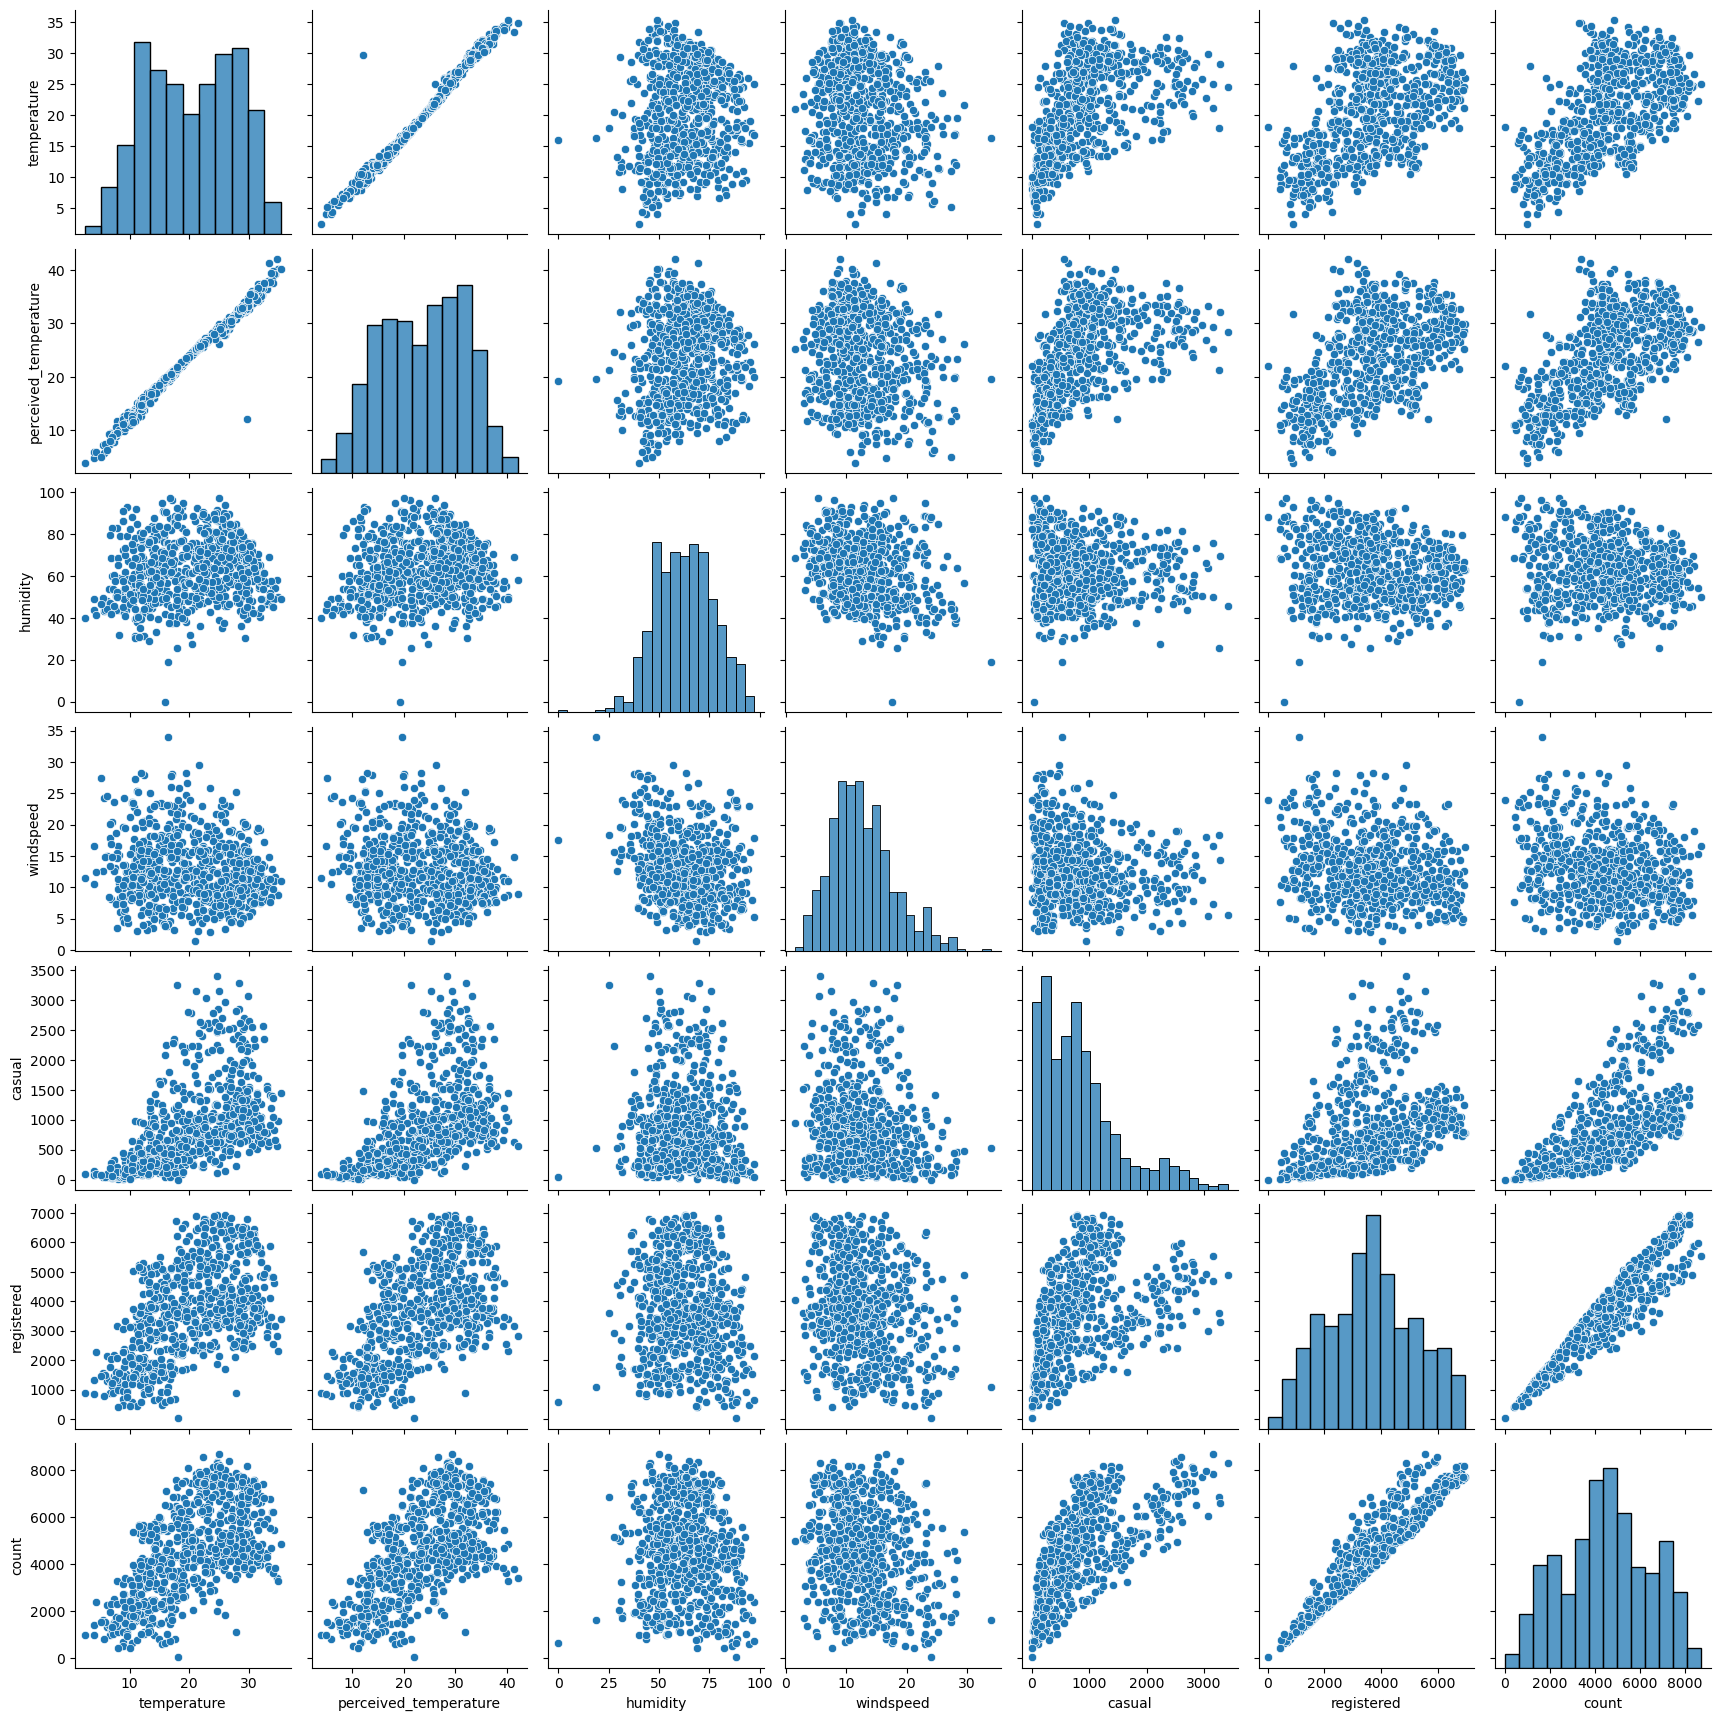

In [121]:
#data visualization

bike_rentals_plot = bike_rentals[bike_rentals_numv]
sns.pairplot(bike_rentals_plot)
plt.show()

### From the pair plot it looks like temperature, perceived_temperature, registered, casual have linear relations with count. Hence we can consider and linear model

#### lets validate this after building model

#### Now build the box plot for the categorical variables

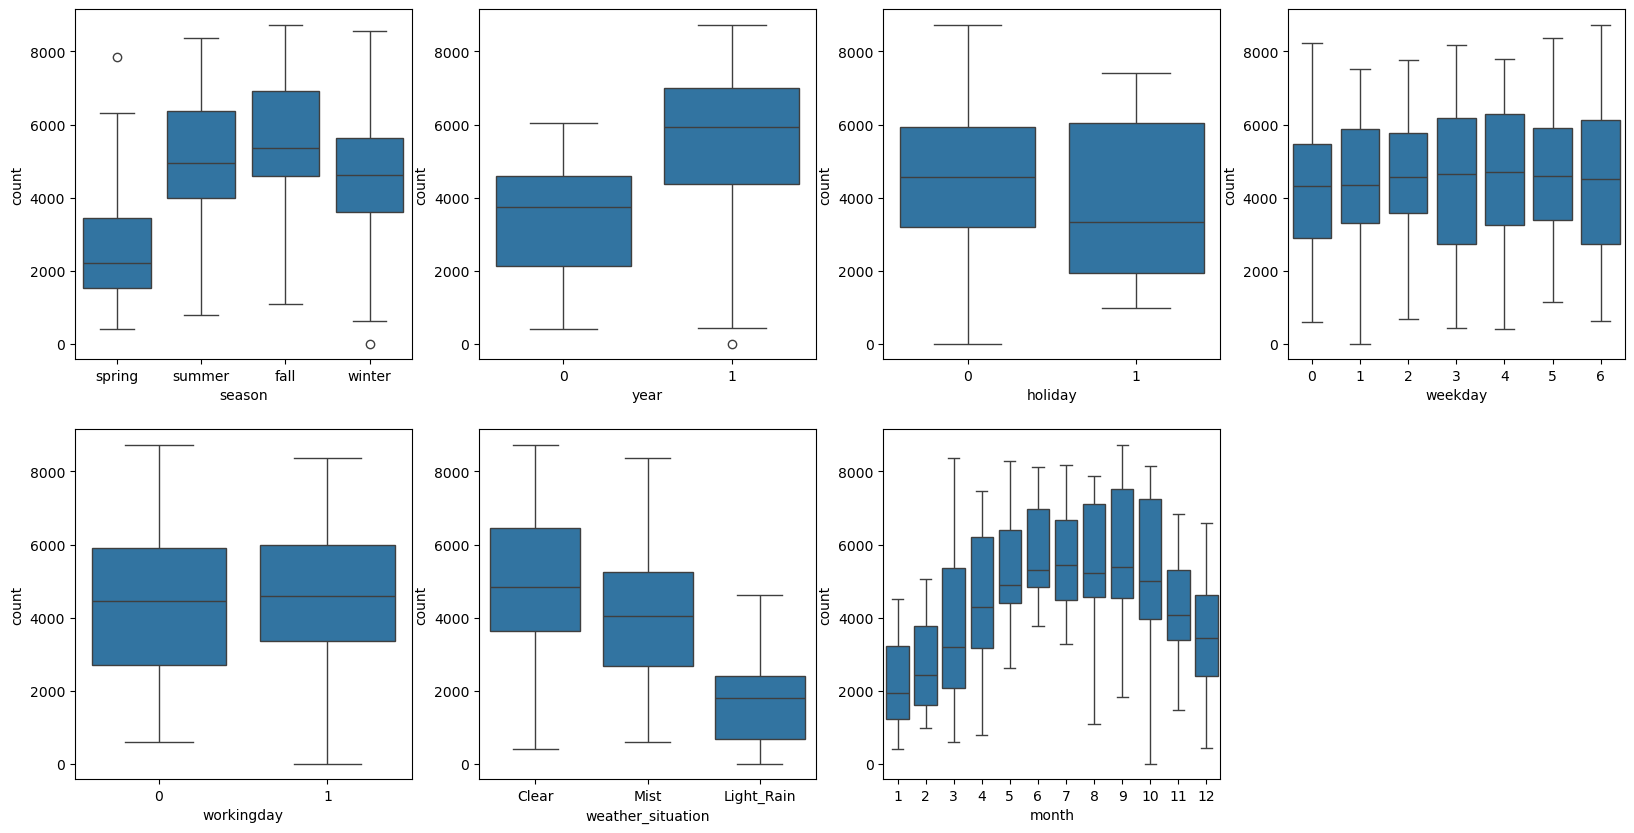

In [122]:
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
sns.boxplot(x='season', y='count', data = bike_rentals)
plt.subplot(2,4,2)
sns.boxplot(x='year', y='count', data = bike_rentals)
plt.subplot(2,4,3)
sns.boxplot(x='holiday', y='count', data = bike_rentals)
plt.subplot(2,4,4)
sns.boxplot(x='weekday', y='count', data = bike_rentals)
plt.subplot(2,4,5)
sns.boxplot(x='workingday', y='count', data = bike_rentals)
plt.subplot(2,4,6)
sns.boxplot(x='weather_situation', y='count', data = bike_rentals)
plt.subplot(2,4,7)
sns.boxplot(x='month', y='count', data = bike_rentals)
plt.show()

### From the box plot it is understood that season, year, weather_situation, holiday, month has a high correlation with count

#### lets update the data set with dummies for the categorical variables

#### categorical variables are season, weekday, weather_situation, month. 
#### the categorical variables like year, holdiday, working day are already having binary values 0, 1 . Hence they need not be replaced with dummies

In [123]:
bike_rentals = upd_with_dummies(bike_rentals,'season')

In [124]:
bike_rentals = upd_with_dummies(bike_rentals,'weekday')

In [125]:
bike_rentals = upd_with_dummies(bike_rentals,'weather_situation')

In [126]:
bike_rentals = upd_with_dummies(bike_rentals,'month')

In [127]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          730 non-null    int64  
 1   holiday                       730 non-null    int64  
 2   workingday                    730 non-null    int64  
 3   temperature                   730 non-null    float64
 4   perceived_temperature         730 non-null    float64
 5   humidity                      730 non-null    float64
 6   windspeed                     730 non-null    float64
 7   casual                        730 non-null    int64  
 8   registered                    730 non-null    int64  
 9   count                         730 non-null    int64  
 10  season_summer                 730 non-null    int64  
 11  season_fall                   730 non-null    int64  
 12  season_winter                 730 non-null    int64  
 13  weekd

### Now lets do a test train split

#### Since data set size is not big enough hence 80% is considered for train set to have more data to train

In [128]:
bike_rentals_train, bike_rentals_test = train_test_split(bike_rentals, train_size=0.8, random_state=100) 

### Lets start rescaling now

In [129]:
scaler = MinMaxScaler()

# scaling of numeric variables
bike_rentals_train[bike_rentals_numv] = scaler.fit_transform(bike_rentals_train[bike_rentals_numv])
bike_rentals_train.head()

,year,holiday,workingday,temperature,perceived_temperature,humidity,windspeed,casual,registered,count,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
367,1,0,1,0.113228,0.061963,0.454701,0.695175,0.026516,0.307104,0.254717,...,0,0,0,0,0,0,0,0,0,0
648,1,0,1,0.468352,0.462175,0.477458,0.299450,0.253581,0.969679,0.868385,...,0,0,0,0,0,0,0,1,0,0
44,0,0,1,0.443431,0.419099,0.387290,0.807474,0.062786,0.243286,0.217556,...,0,0,0,0,0,0,0,0,0,0
705,1,0,1,0.326094,0.318824,0.787463,0.189819,0.105760,0.669795,0.573631,...,0,0,0,0,0,0,0,0,0,1
379,1,0,0,0.133996,0.108365,0.431945,0.449210,0.085949,0.289778,0.263346,...,0,0,0,0,0,0,0,0,0,0


In [130]:
bike_rentals_train.describe()

,year,holiday,workingday,temperature,perceived_temperature,humidity,windspeed,casual,registered,count,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,...,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.513699,0.027397,0.667808,0.537414,0.513175,0.649499,0.319463,0.257519,0.525317,0.515792,...,0.090753,0.077055,0.087329,0.077055,0.075342,0.090753,0.080479,0.092466,0.080479,0.087329
std,0.500241,0.163378,0.471403,0.225336,0.211663,0.144219,0.168114,0.205577,0.230345,0.225336,...,0.287504,0.266907,0.282558,0.266907,0.264169,0.287504,0.272267,0.289931,0.272267,0.282558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.340113,0.331819,0.535852,0.199177,0.096236,0.352512,0.350696,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.545191,0.530558,0.653714,0.294764,0.218379,0.524329,0.522837,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.736512,0.690521,0.752361,0.410413,0.333968,0.698924,0.691872,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [131]:
bike_rentals_test[bike_rentals_numv] = scaler.transform(bike_rentals_test[bike_rentals_numv])  ## for the test set it is only transform and no fit
bike_rentals_test.head()

,year,holiday,workingday,temperature,perceived_temperature,humidity,windspeed,casual,registered,count,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.933557,0.427086,0.692706,...,0,0,0,0,1,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.265163,0.767976,0.712034,...,0,0,0,1,0,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.072539,0.346376,0.303382,...,0,0,0,0,0,0,0,1,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.268820,0.559630,0.547400,...,0,0,0,0,0,1,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.223712,0.608143,0.569029,...,0,0,0,1,0,0,0,0,0,0


In [132]:
bike_rentals_test.describe()

,year,holiday,workingday,temperature,perceived_temperature,humidity,windspeed,casual,registered,count,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,...,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,0.445205,0.034247,0.746575,0.569603,0.542752,0.635933,0.315127,0.261067,0.525614,0.517368,...,0.061644,0.102740,0.075342,0.102740,0.123288,0.061644,0.089041,0.054795,0.089041,0.075342
std,0.498699,0.182488,0.436469,0.238088,0.222120,0.156357,0.161524,0.223963,0.204079,0.212757,...,0.241335,0.304664,0.264852,0.304664,0.329899,0.241335,0.285783,0.228362,0.285783,0.264852
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.009753,0.065261,0.055683,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.250000,0.359075,0.346732,0.534457,0.196160,0.092502,0.398823,0.391251,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.560248,0.544652,0.614856,0.306383,0.214416,0.528877,0.508916,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.801929,0.743337,0.730570,0.411976,0.331759,0.651639,0.649994,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.800793,1.038708,0.955819,0.963300,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Pairplot and subplot gave a picture of which variable holds a linear relationship with price.
#### Now we have data prepared with dummy and also it is scaled. Lets have a heatmap with a correlation to matrix to check the important variables

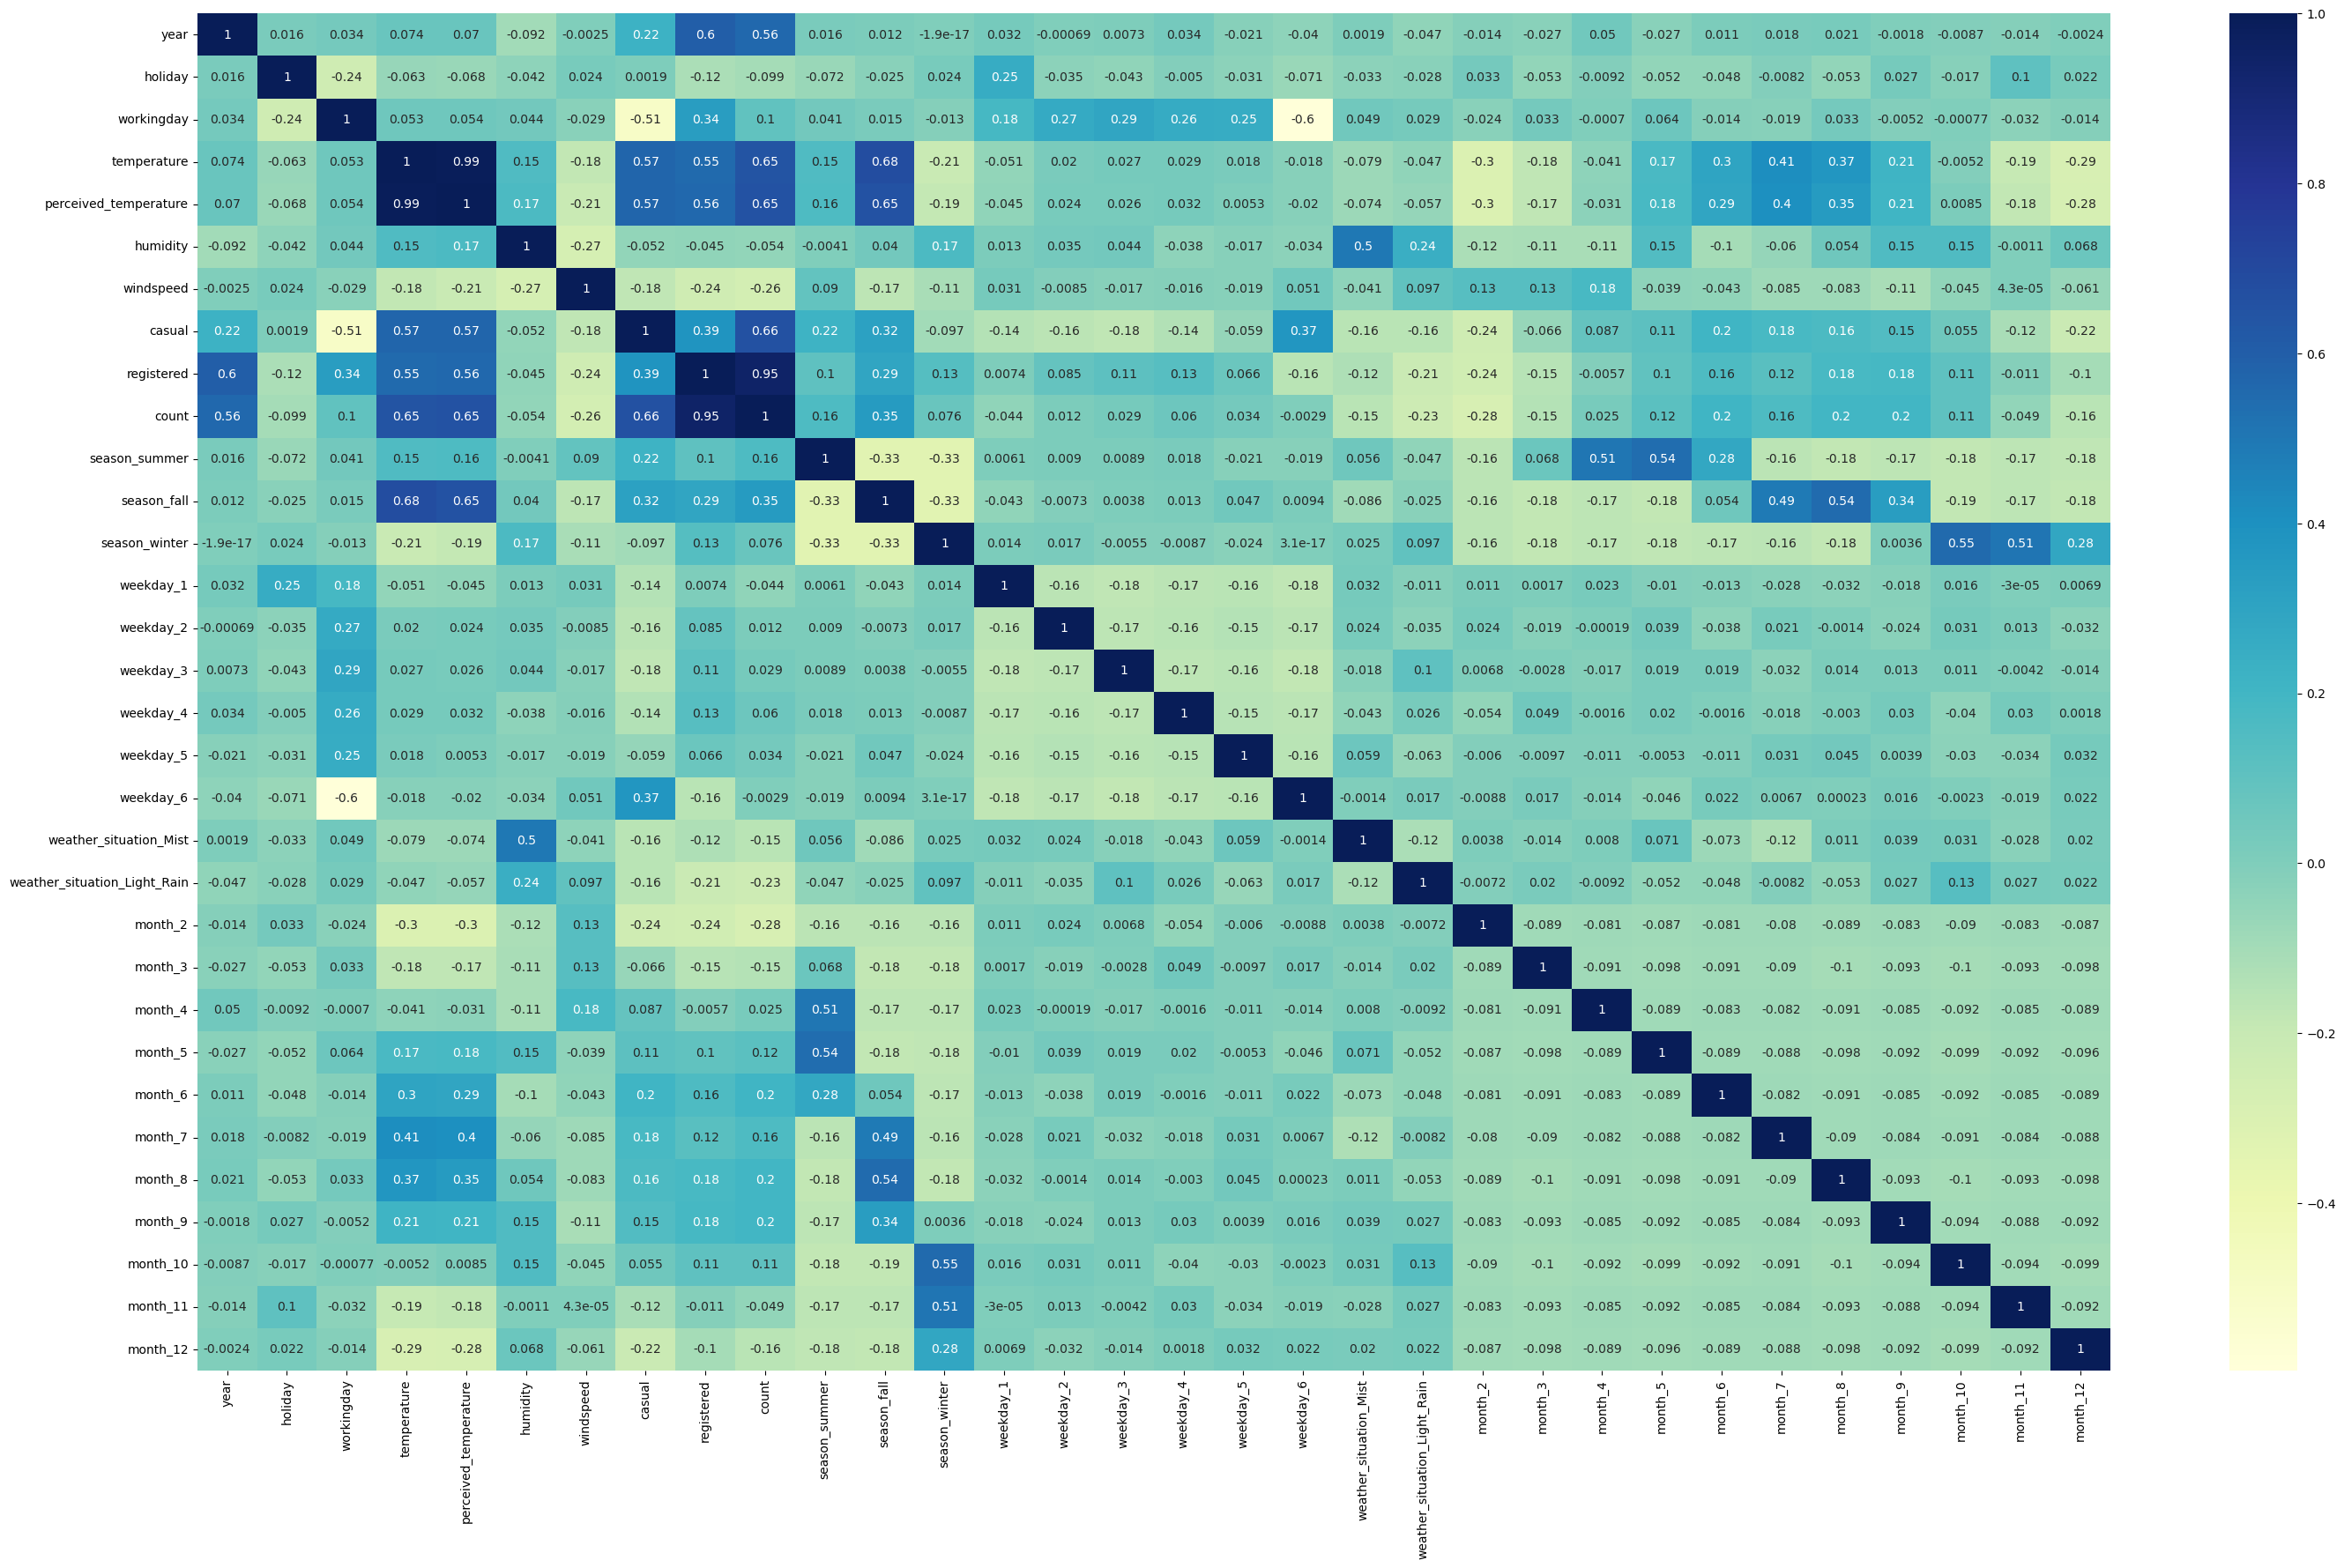

In [133]:
plt.figure(figsize= (35,20))
sns.heatmap(bike_rentals_train.corr(), annot=True, cmap='YlGnBu')
plt.show()

#### Extract x train and y train

In [134]:
X_train_br = bike_rentals_train.copy()
X_train_br.drop('count', axis= 1, inplace=True)
y_train_br = bike_rentals_train['count']

In [135]:
y_train_br.info()

<class 'pandas.core.series.Series'>
Index: 584 entries, 367 to 520
Series name: count
Non-Null Count  Dtype  
--------------  -----  
584 non-null    float64
dtypes: float64(1)
memory usage: 9.1 KB


In [136]:
bike_rentals_train.head()

,year,holiday,workingday,temperature,perceived_temperature,humidity,windspeed,casual,registered,count,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
367,1,0,1,0.113228,0.061963,0.454701,0.695175,0.026516,0.307104,0.254717,...,0,0,0,0,0,0,0,0,0,0
648,1,0,1,0.468352,0.462175,0.477458,0.299450,0.253581,0.969679,0.868385,...,0,0,0,0,0,0,0,1,0,0
44,0,0,1,0.443431,0.419099,0.387290,0.807474,0.062786,0.243286,0.217556,...,0,0,0,0,0,0,0,0,0,0
705,1,0,1,0.326094,0.318824,0.787463,0.189819,0.105760,0.669795,0.573631,...,0,0,0,0,0,0,0,0,0,1
379,1,0,0,0.133996,0.108365,0.431945,0.449210,0.085949,0.289778,0.263346,...,0,0,0,0,0,0,0,0,0,0


#### Extract x test and y test

In [137]:
X_test_br = bike_rentals_test.copy()
X_test_br.drop('count', axis= 1, inplace=True)
y_test_br = bike_rentals_test['count']

## Start building model

# Method1: ( Model building ) Start with a variable that has highest correlation with dependent variable and keep adding one by one based on correlation. 

#### Start with 'registered'

In [138]:
lr_model = fit_to_stats_model(X_train_br[['registered']], y_train_br )
lr_model.params

const         0.028461
registered    0.927691
dtype: float64

In [139]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     5198.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          2.64e-292
Time:                        11:18:36   Log-Likelihood:                 712.42
No. Observations:                 584   AIC:                            -1421.
Df Residuals:                     582   BIC:                            -1412.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.007      3.857      0.000       0.014       0.043
registered     0.9277      0.013     72.095      0.000       0.902       0.953
==============================================================================
Omnibus:                      144.760   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.787
Skew:                           1.464   Prob(JB):                     1.93e-58
Kurtosis:                       4.531   Cond. No.                         5.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### R squared looks very good
### Lets add another variable - 'casual'


In [140]:
lr_model = fit_to_stats_model(X_train_br[['registered', 'casual']], y_train_br )
lr_model.params

const         1.665335e-16
registered    7.968247e-01
casual        3.774735e-01
dtype: float64

In [141]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.152e+32
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:18:42   Log-Likelihood:                 19943.
No. Observations:                 584   AIC:                        -3.988e+04
Df Residuals:                     581   BIC:                        -3.987e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.665e-16   3.74e-17      4.449      0.000     9.3e-17     2.4e-16
registered     0.7968   6.99e-17   1.14e+16      0.000       0.797       0.797
casual         0.3775   7.84e-17   4.82e+15      0.000       0.377       0.377
==============================================================================
Omnibus:                       12.551   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                7.935
Skew:                          -0.127   Prob(JB):                       0.0189
Kurtosis:                       2.489   Cond. No.                         6.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Now it appears that we have a perfect model ( R2 = 1 ) and it is already known , cnf is a linear function of casual and registered from the data set

#### Lets check the VIF

In [142]:
calc_vif(X_train_br[['registered', 'casual']])

,Features,VIF
0,registered,2.95
1,casual,2.95


#### As per the problem domain , registered , casual bears a perfect linear relationship with count.
#### However these are similar to predictor variable count. Other variables are more relaistic to have impact on count.
#### Hence more varaibles should be considered
#### It may be ideal to consider a data set without registered or casual. However lets continue and see how the model shapes up

#### Now with one more variable - 'temperature'

In [143]:
lr_model = fit_to_stats_model(X_train_br[['registered', 'casual','temperature']], y_train_br )
lr_model.params

const         -1.526557e-16
registered     7.968247e-01
casual         3.774735e-01
temperature    4.163336e-17
dtype: float64

In [144]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.136e+32
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:18:56   Log-Likelihood:                 20242.
No. Observations:                 584   AIC:                        -4.048e+04
Df Residuals:                     580   BIC:                        -4.046e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.527e-16   2.53e-17     -6.034      0.000   -2.02e-16   -1.03e-16
registered      0.7968   4.67e-17   1.71e+16      0.000       0.797       0.797
casual          0.3775    5.3e-17   7.12e+15      0.000       0.377       0.377
temperature  4.163e-17   5.36e-17      0.777      0.437   -6.36e-17    1.47e-16
==============================================================================
Omnibus:                       25.628   Durbin-Watson:                   0.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.906
Skew:                           0.504   Prob(JB):                     8.72e-07
Kurtosis:                       3.360   Cond. No.                         9.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Now R squared has already reached 1. More and more variables we add, R2 will never increase further and it will remain as 1
#### we also see p value of temperature is high, indicating it low significance. Are we getting right model?
#### lets add another variable

In [145]:
lr_model = fit_to_stats_model(X_train_br[['registered', 'casual','temperature','perceived_temperature']], y_train_br)
lr_model.params

const                    3.608225e-16
registered               7.968247e-01
casual                   3.774735e-01
temperature              1.110223e-15
perceived_temperature   -8.881784e-16
dtype: float64

In [146]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.676e+31
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:19:07   Log-Likelihood:                 19883.
No. Observations:                 584   AIC:                        -3.976e+04
Df Residuals:                     579   BIC:                        -3.973e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.608e-16   4.72e-17      7.646      0.000    2.68e-16    4.54e-16
registered                0.7968   8.68e-17   9.18e+15      0.000       0.797       0.797
casual                    0.3775   9.82e-17   3.84e+15      0.000       0.377       0.377
temperature             1.11e-15    5.3e-16      2.093      0.037    6.84e-17    2.15e-15
perceived_temperature -8.882e-16   5.66e-16     -1.568      0.117      -2e-15    2.24e-16
==============================================================================
Omnibus:                       26.908   Durbin-Watson:                   0.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.658
Skew:                           0.104   Prob(JB):                     1.01e-16
Kurtosis:                       4.727   Cond. No.                         65.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model is varying widely on following this approach
#### With many variables it will take long time to interpret
#### Lets try another approach

#### Lets build a model with all variables together 

# Method2: ( Model building ) Start with all variables and drop one after another according to significance ( p value ) and multicollinearity ( VIF )

In [147]:
X_train_br_temp = X_train_br.copy()

In [148]:
lr_model = fit_to_stats_model(X_train_br_temp, y_train_br)
lr_model.params

const                          -2.428613e-16
year                           -2.498002e-16
holiday                        -7.424616e-16
workingday                      1.353084e-16
temperature                    -8.326673e-16
perceived_temperature           6.661338e-16
humidity                        2.359224e-16
windspeed                       4.857226e-16
casual                          3.774735e-01
registered                      7.968247e-01
season_summer                   5.551115e-17
season_fall                     4.163336e-17
season_winter                  -1.110223e-16
weekday_1                      -2.914335e-16
weekday_2                      -1.665335e-16
weekday_3                       6.938894e-17
weekday_4                      -1.647987e-17
weekday_5                       1.040834e-16
weekday_6                       1.318390e-16
weather_situation_Mist          1.734723e-17
weather_situation_Light_Rain    3.816392e-16
month_2                        -1.318390e-16
month_3   

In [149]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.708e+30
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:19:25   Log-Likelihood:                 19814.
No. Observations:                 584   AIC:                        -3.957e+04
Df Residuals:                     553   BIC:                        -3.943e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -2.429e-16   1.53e-16     -1.584      0.114   -5.44e-16    5.82e-17
year                         -2.498e-16   6.86e-17     -3.639      0.000   -3.85e-16   -1.15e-16
holiday                      -7.425e-16    1.1e-16     -6.772      0.000   -9.58e-16   -5.27e-16
workingday                    1.353e-16   6.91e-17      1.957      0.051   -4.74e-19    2.71e-16
temperature                  -8.327e-16   7.19e-16     -1.157      0.248   -2.25e-15    5.81e-16
perceived_temperature         6.661e-16   7.03e-16      0.947      0.344   -7.16e-16    2.05e-15
humidity                      2.359e-16   1.93e-16      1.220      0.223   -1.44e-16    6.16e-16
windspeed                     4.857e-16   1.35e-16      3.611      0.000    2.22e-16     7.5e-16
casual                           0.3775   1.93e-16   1.95e+15      0.000       0.377       0.377
registered                       0.7968   2.33e-16   3.41e+15      0.000       0.797       0.797
season_summer                 5.551e-17    1.2e-16      0.462      0.644    -1.8e-16    2.91e-16
season_fall                   4.163e-17   1.45e-16      0.288      0.774   -2.43e-16    3.26e-16
season_winter                 -1.11e-16   1.29e-16     -0.858      0.391   -3.65e-16    1.43e-16
weekday_1                    -2.914e-16    4.8e-17     -6.077      0.000   -3.86e-16   -1.97e-16
weekday_2                    -1.665e-16   5.43e-17     -3.066      0.002   -2.73e-16   -5.98e-17
weekday_3                     6.939e-17   5.28e-17      1.314      0.189   -3.43e-17    1.73e-16
weekday_4                    -1.648e-17   5.44e-17     -0.303      0.762   -1.23e-16    9.03e-17
weekday_5                     1.041e-16   5.47e-17      1.903      0.058   -3.37e-18    2.12e-16
weekday_6                     1.318e-16   7.05e-17      1.871      0.062   -6.57e-18     2.7e-16
weather_situation_Mist        1.735e-17   5.26e-17      0.330      0.742    -8.6e-17    1.21e-16
weather_situation_Light_Rain  3.816e-16   1.46e-16      2.615      0.009     9.5e-17    6.68e-16
month_2                      -1.318e-16   9.77e-17     -1.350      0.178   -3.24e-16       6e-17
month_3                       6.939e-17    1.1e-16      0.632      0.528   -1.46e-16    2.85e-16
month_4                      -3.192e-16   1.66e-16     -1.926      0.055   -6.45e-16    6.29e-18
month_5                      -2.776e-16   1.78e-16     -1.558      0.120   -6.27e-16    7.23e-17
month_6                      -4.649e-16   1.88e-16     -2.471      0.014   -8.34e-16   -9.53e-17
month_7                       -4.51e-16    2.1e-16     -2.149      0.032   -8.63e-16   -3.88e-17
month_8                      -3.331e-16   2.01e-16     -1.659      0.098   -7.28e-16    6.14e-17
month_9                      -4.441e-16    1.8e-16     -2.471      0.014   -

#### Since R2 has reached 1 before with only two variables . Hence it will definitely be 1 with all variables.
#### Impact of other variables if being shadowed by registered and casual

In [150]:
calc_vif(X_train_br_temp)

C:\Users\Anirudha\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
1,holiday,inf
2,workingday,inf
13,weekday_2,inf
14,weekday_3,inf
12,weekday_1,inf
16,weekday_5,inf
15,weekday_4,inf
3,temperature,488.76
4,perceived_temperature,424.39
8,registered,49.34


#### Season_fall has the highest p value and also a high VIF
#### Lets drop this first and recalculate

In [151]:
X_train_br_temp.drop('season_fall', axis = 1, inplace=True )

In [152]:
lr_model = fit_to_stats_model(X_train_br_temp, y_train_br)
lr_model.params


const                          -2.081668e-16
year                            0.000000e+00
holiday                        -3.677614e-16
workingday                     -2.775558e-16
temperature                    -1.165734e-15
perceived_temperature           1.554312e-15
humidity                       -9.714451e-17
windspeed                       4.857226e-16
casual                          3.774735e-01
registered                      7.968247e-01
season_summer                  -9.020562e-17
season_winter                  -1.023487e-16
weekday_1                       0.000000e+00
weekday_2                       2.359224e-16
weekday_3                       3.469447e-17
weekday_4                      -7.112366e-17
weekday_5                      -5.551115e-17
weekday_6                      -7.632783e-17
weather_situation_Mist          7.632783e-17
weather_situation_Light_Rain   -2.844947e-16
month_2                         2.775558e-17
month_3                        -1.942890e-16
month_4   

In [153]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.624e+31
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:20:45   Log-Likelihood:                 20165.
No. Observations:                 584   AIC:                        -4.027e+04
Df Residuals:                     554   BIC:                        -4.014e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -2.082e-16   8.39e-17     -2.482      0.013   -3.73e-16   -4.34e-17
year                                  0   3.73e-17          0      1.000   -7.33e-17    7.33e-17
holiday                      -3.678e-16      6e-17     -6.128      0.000   -4.86e-16    -2.5e-16
workingday                   -2.776e-16   3.78e-17     -7.338      0.000   -3.52e-16   -2.03e-16
temperature                  -1.166e-15   3.93e-16     -2.968      0.003   -1.94e-15   -3.94e-16
perceived_temperature         1.554e-15   3.85e-16      4.039      0.000    7.98e-16    2.31e-15
humidity                     -9.714e-17   1.06e-16     -0.918      0.359   -3.05e-16    1.11e-16
windspeed                     4.857e-16   7.36e-17      6.600      0.000    3.41e-16     6.3e-16
casual                           0.3775   1.06e-16   3.57e+15      0.000       0.377       0.377
registered                       0.7968   1.27e-16   6.28e+15      0.000       0.797       0.797
season_summer                -9.021e-17    5.5e-17     -1.640      0.102   -1.98e-16    1.78e-17
season_winter                -1.023e-16   6.02e-17     -1.700      0.090   -2.21e-16    1.59e-17
weekday_1                             0   2.63e-17          0      1.000   -5.16e-17    5.16e-17
weekday_2                     2.359e-16   2.97e-17      7.935      0.000    1.78e-16    2.94e-16
weekday_3                     3.469e-17   2.89e-17      1.201      0.230    -2.2e-17    9.14e-17
weekday_4                    -7.112e-17   2.98e-17     -2.389      0.017    -1.3e-16   -1.27e-17
weekday_5                    -5.551e-17   2.99e-17     -1.854      0.064   -1.14e-16     3.3e-18
weekday_6                    -7.633e-17   3.86e-17     -1.978      0.048   -1.52e-16   -5.44e-19
weather_situation_Mist        7.633e-17   2.88e-17      2.652      0.008    1.98e-17    1.33e-16
weather_situation_Light_Rain -2.845e-16   7.97e-17     -3.570      0.000   -4.41e-16   -1.28e-16
month_2                       2.776e-17   5.34e-17      0.519      0.604   -7.72e-17    1.33e-16
month_3                      -1.943e-16   5.96e-17     -3.258      0.001   -3.11e-16   -7.72e-17
month_4                       1.318e-16   8.57e-17      1.538      0.125   -3.65e-17       3e-16
month_5                       1.388e-16   9.41e-17      1.475      0.141    -4.6e-17    3.24e-16
month_6                       4.163e-17   9.57e-17      0.435      0.664   -1.46e-16     2.3e-16
month_7                      -3.469e-16   9.41e-17     -3.688      0.000   -5.32e-16   -1.62e-16
month_8                        -3.4e-16   8.78e-17     -3.872      0.000   -5.13e-16   -1.68e-16
month_9                      -3.331e-16   8.06e-17     -4.134      0.000   -4.91e-16   -1.75e-16
month_10                      2.776e-17   8.43e-17      0.329      0.742   -

In [154]:
calc_vif(X_train_br_temp)

C:\Users\Anirudha\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
1,holiday,inf
2,workingday,inf
13,weekday_3,inf
11,weekday_1,inf
12,weekday_2,inf
14,weekday_4,inf
15,weekday_5,inf
3,temperature,485.72
4,perceived_temperature,423.50
8,registered,48.70


#### Now this has totally changed the model.
#### year is of highest p value now whereas temperature became very significant ( very low p )
#### year also has a high vif
#### lets drop the year now

In [155]:
X_train_br_temp.drop('year', axis = 1, inplace=True )
lr_model = fit_to_stats_model(X_train_br_temp, y_train_br)
lr_model.params

const                          -2.151057e-16
holiday                         1.040834e-17
workingday                     -8.847090e-16
temperature                     1.665335e-15
perceived_temperature          -2.553513e-15
humidity                        3.747003e-16
windspeed                       4.163336e-16
casual                          3.774735e-01
registered                      7.968247e-01
season_summer                  -6.938894e-18
season_winter                  -4.267420e-16
weekday_1                       2.220446e-16
weekday_2                       2.359224e-16
weekday_3                      -9.367507e-17
weekday_4                      -2.081668e-17
weekday_5                       4.163336e-17
weekday_6                       4.787837e-16
weather_situation_Mist         -1.630640e-16
weather_situation_Light_Rain    1.387779e-17
month_2                         1.942890e-16
month_3                        -7.632783e-17
month_4                         1.526557e-16
month_5   

In [156]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.403e+30
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:21:14   Log-Likelihood:                 19439.
No. Observations:                 584   AIC:                        -3.882e+04
Df Residuals:                     555   BIC:                        -3.869e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -2.151e-16    2.9e-16     -0.741      0.459   -7.85e-16    3.55e-16
holiday                       1.041e-17   2.08e-16      0.050      0.960   -3.97e-16    4.18e-16
workingday                   -8.847e-16   1.21e-16     -7.294      0.000   -1.12e-15   -6.46e-16
temperature                   1.665e-15   1.36e-15      1.225      0.221   -1.01e-15    4.34e-15
perceived_temperature        -2.554e-15   1.33e-15     -1.918      0.056   -5.17e-15    6.15e-17
humidity                      3.747e-16   3.66e-16      1.023      0.307   -3.45e-16    1.09e-15
windspeed                     4.163e-16    2.5e-16      1.665      0.097   -7.49e-17    9.08e-16
casual                           0.3775   3.66e-16   1.03e+15      0.000       0.377       0.377
registered                       0.7968   2.68e-16   2.97e+15      0.000       0.797       0.797
season_summer                -6.939e-18    1.9e-16     -0.037      0.971    -3.8e-16    3.66e-16
season_winter                -4.267e-16   2.01e-16     -2.127      0.034   -8.21e-16   -3.26e-17
weekday_1                      2.22e-16   9.09e-17      2.442      0.015    4.35e-17    4.01e-16
weekday_2                     2.359e-16   1.03e-16      2.295      0.022     3.4e-17    4.38e-16
weekday_3                    -9.368e-17   9.93e-17     -0.944      0.346   -2.89e-16    1.01e-16
weekday_4                    -2.082e-17   1.03e-16     -0.203      0.839   -2.22e-16    1.81e-16
weekday_5                     4.163e-17   1.03e-16      0.403      0.687   -1.61e-16    2.45e-16
weekday_6                     4.788e-16   1.32e-16      3.628      0.000     2.2e-16    7.38e-16
weather_situation_Mist       -1.631e-16   9.67e-17     -1.686      0.092   -3.53e-16    2.69e-17
weather_situation_Light_Rain  1.388e-17   2.59e-16      0.054      0.957   -4.94e-16    5.22e-16
month_2                       1.943e-16   1.84e-16      1.054      0.292   -1.68e-16    5.56e-16
month_3                      -7.633e-17   2.05e-16     -0.373      0.709   -4.78e-16    3.26e-16
month_4                       1.527e-16   2.95e-16      0.518      0.605   -4.26e-16    7.32e-16
month_5                        1.11e-16   3.21e-16      0.346      0.730    -5.2e-16    7.42e-16
month_6                       3.886e-16   3.26e-16      1.191      0.234   -2.52e-16    1.03e-15
month_7                       2.359e-16   3.22e-16      0.732      0.464   -3.97e-16    8.69e-16
month_8                       2.567e-16   2.97e-16      0.864      0.388   -3.27e-16     8.4e-16
month_9                        1.11e-16   2.68e-16      0.414      0.679   -4.16e-16    6.38e-16
month_10                     -4.857e-17    2.9e-16     -0.168      0.867   -6.18e-16    5.21e-16
month_11                      1.665e-16   2.72e-16      0.612      0.541   -

In [157]:
calc_vif(X_train_br_temp)

C:\Users\Anirudha\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Features,VIF
0,holiday,inf
1,workingday,inf
10,weekday_1,inf
12,weekday_3,inf
11,weekday_2,inf
14,weekday_5,inf
13,weekday_4,inf
2,temperature,485.35
3,perceived_temperature,422.63
4,humidity,21.15


#### holiday has very high p value. Lets drop it

In [158]:
X_train_br_temp.drop('holiday', axis = 1 , inplace=True)
lr_model = fit_to_stats_model(X_train_br_temp, y_train_br)
lr_model.params

const                          -2.012279e-16
workingday                     -4.024558e-16
temperature                     9.436896e-16
perceived_temperature          -7.771561e-16
humidity                        3.885781e-16
windspeed                      -1.415534e-15
casual                          3.774735e-01
registered                      7.968247e-01
season_summer                  -7.598089e-16
season_winter                  -3.851086e-16
weekday_1                       5.481726e-16
weekday_2                       1.526557e-16
weekday_3                       3.053113e-16
weekday_4                       1.942890e-16
weekday_5                       4.683753e-16
weekday_6                      -3.469447e-17
weather_situation_Mist         -1.873501e-16
weather_situation_Light_Rain    1.158795e-15
month_2                        -6.938894e-18
month_3                         4.163336e-16
month_4                         9.645063e-16
month_5                         2.498002e-16
month_6   

In [159]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.811e+30
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:22:12   Log-Likelihood:                 19514.
No. Observations:                 584   AIC:                        -3.897e+04
Df Residuals:                     555   BIC:                        -3.884e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -2.012e-16   2.56e-16     -0.787      0.431   -7.03e-16    3.01e-16
workingday                   -4.025e-16   2.17e-16     -1.854      0.064   -8.29e-16     2.4e-17
temperature                   9.437e-16    1.2e-15      0.789      0.431   -1.41e-15    3.29e-15
perceived_temperature        -7.772e-16   1.17e-15     -0.663      0.507   -3.08e-15    1.52e-15
humidity                      3.886e-16   3.22e-16      1.206      0.229   -2.45e-16    1.02e-15
windspeed                    -1.416e-15    2.2e-16     -6.431      0.000   -1.85e-15   -9.83e-16
casual                           0.3775   3.23e-16   1.17e+15      0.000       0.377       0.377
registered                       0.7968   2.36e-16   3.37e+15      0.000       0.797       0.797
season_summer                -7.598e-16   1.67e-16     -4.547      0.000   -1.09e-15   -4.32e-16
season_winter                -3.851e-16   1.77e-16     -2.180      0.030   -7.32e-16   -3.82e-17
weekday_1                     5.482e-16   2.15e-16      2.550      0.011    1.26e-16     9.7e-16
weekday_2                     1.527e-16   2.37e-16      0.643      0.520   -3.13e-16    6.19e-16
weekday_3                     3.053e-16   2.36e-16      1.295      0.196   -1.58e-16    7.68e-16
weekday_4                     1.943e-16   2.36e-16      0.824      0.410   -2.69e-16    6.57e-16
weekday_5                     4.684e-16   2.37e-16      1.976      0.049    2.82e-18    9.34e-16
weekday_6                    -3.469e-17   1.16e-16     -0.299      0.765   -2.63e-16    1.93e-16
weather_situation_Mist       -1.874e-16   8.51e-17     -2.201      0.028   -3.55e-16   -2.01e-17
weather_situation_Light_Rain  1.159e-15   2.28e-16      5.091      0.000    7.12e-16    1.61e-15
month_2                      -6.939e-18   1.62e-16     -0.043      0.966   -3.26e-16    3.12e-16
month_3                       4.163e-16    1.8e-16      2.312      0.021    6.26e-17     7.7e-16
month_4                       9.645e-16   2.59e-16      3.717      0.000    4.55e-16    1.47e-15
month_5                       2.498e-16   2.83e-16      0.884      0.377   -3.05e-16    8.05e-16
month_6                       5.967e-16   2.87e-16      2.079      0.038    3.28e-17    1.16e-15
month_7                      -1.665e-16   2.84e-16     -0.587      0.557   -7.23e-16     3.9e-16
month_8                      -3.331e-16   2.62e-16     -1.273      0.203   -8.47e-16    1.81e-16
month_9                      -2.082e-16   2.36e-16     -0.882      0.378   -6.72e-16    2.55e-16
month_10                     -4.094e-16   2.55e-16     -1.604      0.109   -9.11e-16    9.18e-17
month_11                     -1.388e-16   2.39e-16     -0.580      0.562   -6.09e-16    3.31e-16
month_12                     -3.053e-16   1.92e-16     -1.593      0.112   -

In [160]:
calc_vif(X_train_br_temp)

,Features,VIF
1,temperature,485.35
2,perceived_temperature,422.63
0,workingday,31.48
3,humidity,21.15
6,registered,18.03
5,casual,10.79
11,weekday_3,8.35
8,season_winter,7.79
10,weekday_2,7.35
12,weekday_4,7.30


#### model summary is varying a lot with gradual building, lets follow some automated approach

# Method3.1: ( Model building ) Start with RFE and gradually drop or add variables

#### There are many nummeric and well as categorical varaibles. Lets start RFE with 10 features

In [161]:
X_train_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 584 entries, 367 to 520
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          584 non-null    int64  
 1   holiday                       584 non-null    int64  
 2   workingday                    584 non-null    int64  
 3   temperature                   584 non-null    float64
 4   perceived_temperature         584 non-null    float64
 5   humidity                      584 non-null    float64
 6   windspeed                     584 non-null    float64
 7   casual                        584 non-null    float64
 8   registered                    584 non-null    float64
 9   season_summer                 584 non-null    int64  
 10  season_fall                   584 non-null    int64  
 11  season_winter                 584 non-null    int64  
 12  weekday_1                     584 non-null    int64  
 13  weekday_

In [162]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          730 non-null    int64  
 1   holiday                       730 non-null    int64  
 2   workingday                    730 non-null    int64  
 3   temperature                   730 non-null    float64
 4   perceived_temperature         730 non-null    float64
 5   humidity                      730 non-null    float64
 6   windspeed                     730 non-null    float64
 7   casual                        730 non-null    int64  
 8   registered                    730 non-null    int64  
 9   count                         730 non-null    int64  
 10  season_summer                 730 non-null    int64  
 11  season_fall                   730 non-null    int64  
 12  season_winter                 730 non-null    int64  
 13  weekd

In [163]:
lm = LinearRegression()
lm.fit(X_train_br, y_train_br ) 
# we do not need constant for Liner Regression from sklearn

rfe_br = RFE(estimator=lm, n_features_to_select=10)
rfe_br = rfe_br.fit(X_train_br, y_train_br)

In [164]:
list(zip(X_train_br.columns, rfe_br.support_, rfe_br.ranking_))

[('year', np.True_, np.int64(1)),
 ('holiday', np.False_, np.int64(13)),
 ('workingday', np.False_, np.int64(5)),
 ('temperature', np.True_, np.int64(1)),
 ('perceived_temperature', np.False_, np.int64(2)),
 ('humidity', np.True_, np.int64(1)),
 ('windspeed', np.True_, np.int64(1)),
 ('casual', np.True_, np.int64(1)),
 ('registered', np.True_, np.int64(1)),
 ('season_summer', np.True_, np.int64(1)),
 ('season_fall', np.False_, np.int64(4)),
 ('season_winter', np.False_, np.int64(6)),
 ('weekday_1', np.False_, np.int64(20)),
 ('weekday_2', np.False_, np.int64(17)),
 ('weekday_3', np.False_, np.int64(19)),
 ('weekday_4', np.False_, np.int64(16)),
 ('weekday_5', np.False_, np.int64(12)),
 ('weekday_6', np.True_, np.int64(1)),
 ('weather_situation_Mist', np.False_, np.int64(15)),
 ('weather_situation_Light_Rain', np.False_, np.int64(9)),
 ('month_2', np.False_, np.int64(22)),
 ('month_3', np.False_, np.int64(10)),
 ('month_4', np.False_, np.int64(8)),
 ('month_5', np.False_, np.int64(11)),

In [165]:
col = X_train_br.columns[rfe_br.support_]
X_train_br_rfe = X_train_br[col]
X_train_br_rfe_temp = X_train_br_rfe.copy()


In [166]:
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            8.430756e-16
year             2.532696e-16
temperature     -1.457168e-15
humidity         1.804112e-16
windspeed        2.498002e-16
casual           3.774735e-01
registered       7.968247e-01
season_summer    5.273559e-16
weekday_6       -4.857226e-17
month_10         1.228184e-15
month_11         3.608225e-16
dtype: float64

In [167]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.027e+30
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:22:44   Log-Likelihood:                 19639.
No. Observations:                 584   AIC:                        -3.926e+04
Df Residuals:                     573   BIC:                        -3.921e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.431e-16   1.73e-16      4.878      0.000    5.04e-16    1.18e-15
year           2.533e-16   7.35e-17      3.446      0.001    1.09e-16    3.98e-16
temperature   -1.457e-15   1.88e-16     -7.737      0.000   -1.83e-15   -1.09e-15
humidity       1.804e-16   1.98e-16      0.912      0.362   -2.08e-16    5.69e-16
windspeed      2.498e-16   1.71e-16      1.464      0.144   -8.53e-17    5.85e-16
casual            0.3775   1.88e-16   2.01e+15      0.000       0.377       0.377
registered        0.7968   2.01e-16   3.97e+15      0.000       0.797       0.797
season_summer  5.274e-16   6.41e-17      8.232      0.000    4.02e-16    6.53e-16
weekday_6     -4.857e-17    8.3e-17     -0.585      0.559   -2.12e-16    1.14e-16
month_10       1.228e-15    9.5e-17     12.931      0.000    1.04e-15    1.41e-15
month_11       3.608e-16   9.85e-17      3.665      0.000    1.67e-16    5.54e-16
==============================================================================
Omnibus:                       20.464   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.230
Skew:                           0.091   Prob(JB):                      0.00601
Kurtosis:                       2.378   Cond. No.                         20.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
1,temperature,18.90
5,registered,17.73
2,humidity,9.29
4,casual,5.92
0,year,4.28
3,windspeed,3.70
7,weekday_6,1.64
6,season_summer,1.59
8,month_10,1.29
9,month_11,1.24


#### Since weekday_6 has a high p , let drop that first and build the model again

In [169]:
X_train_br_rfe_temp.drop('weekday_6', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            6.522560e-16
year             3.504141e-16
temperature      2.775558e-17
humidity        -1.665335e-16
windspeed       -1.734723e-16
casual           3.774735e-01
registered       7.968247e-01
season_summer    1.994932e-16
month_10        -5.551115e-17
month_11         6.245005e-17
dtype: float64

In [170]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.386e+31
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:23:06   Log-Likelihood:                 19767.
No. Observations:                 584   AIC:                        -3.951e+04
Df Residuals:                     574   BIC:                        -3.947e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.523e-16   1.38e-16      4.715      0.000    3.81e-16    9.24e-16
year           3.504e-16   5.89e-17      5.946      0.000    2.35e-16    4.66e-16
temperature    2.776e-17   1.49e-16      0.186      0.852   -2.65e-16     3.2e-16
humidity      -1.665e-16   1.58e-16     -1.052      0.293   -4.78e-16    1.44e-16
windspeed     -1.735e-16   1.36e-16     -1.273      0.203   -4.41e-16    9.41e-17
casual            0.3775   1.31e-16   2.89e+15      0.000       0.377       0.377
registered        0.7968   1.59e-16      5e+15      0.000       0.797       0.797
season_summer  1.995e-16    5.1e-17      3.913      0.000    9.94e-17       3e-16
month_10      -5.551e-17   7.61e-17     -0.729      0.466   -2.05e-16     9.4e-17
month_11       6.245e-17    7.9e-17      0.791      0.429   -9.26e-17    2.18e-16
==============================================================================
Omnibus:                       39.895   Durbin-Watson:                   0.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.384
Skew:                          -0.159   Prob(JB):                     0.000277
Kurtosis:                       2.244   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [171]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
1,temperature,18.33
5,registered,17.44
2,humidity,8.96
4,casual,4.38
0,year,4.28
3,windspeed,3.59
6,season_summer,1.56
7,month_10,1.28
8,month_11,1.24


#### temperature has high p and high VIF. Next to drop is temperature

In [172]:
X_train_br_rfe_temp.drop('temperature', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            3.608225e-16
year            -1.873501e-16
humidity        -1.040834e-15
windspeed        9.228729e-16
casual           3.774735e-01
registered       7.968247e-01
season_summer   -1.960238e-16
month_10         3.226586e-16
month_11         6.938894e-18
dtype: float64

In [173]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.136e+31
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:23:32   Log-Likelihood:                 19858.
No. Observations:                 584   AIC:                        -3.970e+04
Df Residuals:                     575   BIC:                        -3.966e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.608e-16   1.18e-16      3.071      0.002     1.3e-16    5.92e-16
year          -1.874e-16   4.41e-17     -4.244      0.000   -2.74e-16   -1.01e-16
humidity      -1.041e-15   1.27e-16     -8.167      0.000   -1.29e-15   -7.91e-16
windspeed      9.229e-16   1.14e-16      8.066      0.000    6.98e-16    1.15e-15
casual            0.3775   9.43e-17      4e+15      0.000       0.377       0.377
registered        0.7968   1.04e-16   7.64e+15      0.000       0.797       0.797
season_summer  -1.96e-16   4.33e-17     -4.529      0.000   -2.81e-16   -1.11e-16
month_10       3.227e-16   6.29e-17      5.128      0.000    1.99e-16    4.46e-16
month_11       6.939e-18   6.51e-17      0.107      0.915   -1.21e-16    1.35e-16
==============================================================================
Omnibus:                       14.420   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.071
Skew:                          -0.393   Prob(JB):                     0.000534
Kurtosis:                       2.987   Cond. No.                         16.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
4,registered,9.92
1,humidity,7.27
2,windspeed,3.51
0,year,3.32
3,casual,3.15
5,season_summer,1.55
6,month_10,1.21
7,month_11,1.15


In [175]:
X_train_br_rfe_temp.drop('month_11', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const           -4.024558e-16
year            -2.775558e-16
humidity        -2.775558e-16
windspeed       -8.396062e-16
casual           3.774735e-01
registered       7.968247e-01
season_summer    3.989864e-16
month_10         2.511880e-15
dtype: float64

In [176]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.286e+30
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:23:41   Log-Likelihood:                 19462.
No. Observations:                 584   AIC:                        -3.891e+04
Df Residuals:                     576   BIC:                        -3.887e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.025e-16   2.31e-16     -1.739      0.083   -8.57e-16     5.2e-17
year          -2.776e-16   8.69e-17     -3.193      0.001   -4.48e-16   -1.07e-16
humidity      -2.776e-16   2.51e-16     -1.105      0.270   -7.71e-16    2.16e-16
windspeed     -8.396e-16   2.25e-16     -3.724      0.000   -1.28e-15   -3.97e-16
casual            0.3775   1.85e-16   2.04e+15      0.000       0.377       0.377
registered        0.7968   2.05e-16   3.89e+15      0.000       0.797       0.797
season_summer   3.99e-16    8.4e-17      4.752      0.000    2.34e-16    5.64e-16
month_10       2.512e-15   1.23e-16     20.435      0.000    2.27e-15    2.75e-15
==============================================================================
Omnibus:                      258.043   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              871.667
Skew:                          -2.170   Prob(JB):                    5.25e-190
Kurtosis:                       7.122   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
4,registered,9.83
1,humidity,7.21
2,windspeed,3.50
0,year,3.32
3,casual,3.14
5,season_summer,1.49
6,month_10,1.19


#### Next to drop is 'humidity'

In [178]:
X_train_br_rfe_temp.drop('humidity', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            3.191891e-16
year             2.567391e-16
windspeed        1.526557e-16
casual           3.774735e-01
registered       7.968247e-01
season_summer    9.194034e-17
month_10         2.775558e-17
dtype: float64

In [179]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.657e+31
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:23:59   Log-Likelihood:                 19930.
No. Observations:                 584   AIC:                        -3.985e+04
Df Residuals:                     577   BIC:                        -3.982e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.192e-16   5.65e-17      5.649      0.000    2.08e-16     4.3e-16
year           2.567e-16   3.89e-17      6.595      0.000     1.8e-16    3.33e-16
windspeed      1.527e-16   9.64e-17      1.584      0.114   -3.67e-17    3.42e-16
casual            0.3775   8.26e-17   4.57e+15      0.000       0.377       0.377
registered        0.7968   9.15e-17   8.71e+15      0.000       0.797       0.797
season_summer  9.194e-17   3.75e-17      2.455      0.014    1.84e-17    1.66e-16
month_10       2.776e-17   5.42e-17      0.512      0.609   -7.87e-17    1.34e-16
==============================================================================
Omnibus:                       11.464   Durbin-Watson:                   0.229
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.038
Skew:                          -0.298   Prob(JB):                      0.00401
Kurtosis:                       2.684   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [180]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
3,registered,6.76
0,year,3.17
2,casual,3.10
1,windspeed,2.50
4,season_summer,1.49
5,month_10,1.18


In [181]:
X_train_br_rfe_temp.drop('month_10', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            3.400058e-16
year            -1.665335e-16
windspeed        8.326673e-17
casual           3.774735e-01
registered       7.968247e-01
season_summer    2.766884e-16
dtype: float64

In [182]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.551e+31
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:24:12   Log-Likelihood:                 20157.
No. Observations:                 584   AIC:                        -4.030e+04
Df Residuals:                     578   BIC:                        -4.028e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            3.4e-16   3.83e-17      8.876      0.000    2.65e-16    4.15e-16
year          -1.665e-16   2.62e-17     -6.348      0.000   -2.18e-16   -1.15e-16
windspeed      8.327e-17   6.53e-17      1.275      0.203    -4.5e-17    2.12e-16
casual            0.3775   5.59e-17   6.75e+15      0.000       0.377       0.377
registered        0.7968   6.14e-17    1.3e+16      0.000       0.797       0.797
season_summer  2.767e-16   2.48e-17     11.147      0.000    2.28e-16    3.25e-16
==============================================================================
Omnibus:                        7.768   Durbin-Watson:                   1.114
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                5.984
Skew:                          -0.143   Prob(JB):                       0.0502
Kurtosis:                       2.595   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
3,registered,6.51
0,year,3.13
2,casual,3.09
1,windspeed,2.50
4,season_summer,1.43


#### Lets choose to drop that has high collinearity

#### hence drop 'registered'

In [184]:
X_train_br_rfe_temp.drop('registered', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            0.330699
year             0.201201
windspeed       -0.225783
casual           0.570689
season_summer    0.027991
dtype: float64

In [185]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     265.6
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.83e-129
Time:                        11:24:23   Log-Likelihood:                 346.37
No. Observations:                 584   AIC:                            -682.7
Df Residuals:                     579   BIC:                            -660.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3307      0.015     21.436      0.000       0.300       0.361
year              0.2012      0.011     17.624      0.000       0.179       0.224
windspeed        -0.2258      0.034     -6.649      0.000      -0.292      -0.159
casual            0.5707      0.029     19.639      0.000       0.514       0.628
season_summer     0.0280      0.013      2.099      0.036       0.002       0.054
==============================================================================
Omnibus:                       13.046   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               11.430
Skew:                          -0.278   Prob(JB):                      0.00330
Kurtosis:                       2.598   Cond. No.                         8.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
2,casual,2.24
1,windspeed,2.07
0,year,2.03
3,season_summer,1.42


#### Now in terms of significance and collinearity , model looks very good
#### However the R squared dropped significantly
#### Can we try to do something else
#### drop registered in the beginning and see if r2 is better

# Method3.2: ( Model building ) Start with RFE and gradually drop or add variables

#### Reuse the same RFE data set and drop based on some other metrix and analysis so far

In [187]:
X_train_br_rfe_temp = X_train_br_rfe.copy()

In [188]:
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            8.430756e-16
year             2.532696e-16
temperature     -1.457168e-15
humidity         1.804112e-16
windspeed        2.498002e-16
casual           3.774735e-01
registered       7.968247e-01
season_summer    5.273559e-16
weekday_6       -4.857226e-17
month_10         1.228184e-15
month_11         3.608225e-16
dtype: float64

In [189]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.027e+30
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:24:32   Log-Likelihood:                 19639.
No. Observations:                 584   AIC:                        -3.926e+04
Df Residuals:                     573   BIC:                        -3.921e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.431e-16   1.73e-16      4.878      0.000    5.04e-16    1.18e-15
year           2.533e-16   7.35e-17      3.446      0.001    1.09e-16    3.98e-16
temperature   -1.457e-15   1.88e-16     -7.737      0.000   -1.83e-15   -1.09e-15
humidity       1.804e-16   1.98e-16      0.912      0.362   -2.08e-16    5.69e-16
windspeed      2.498e-16   1.71e-16      1.464      0.144   -8.53e-17    5.85e-16
casual            0.3775   1.88e-16   2.01e+15      0.000       0.377       0.377
registered        0.7968   2.01e-16   3.97e+15      0.000       0.797       0.797
season_summer  5.274e-16   6.41e-17      8.232      0.000    4.02e-16    6.53e-16
weekday_6     -4.857e-17    8.3e-17     -0.585      0.559   -2.12e-16    1.14e-16
month_10       1.228e-15    9.5e-17     12.931      0.000    1.04e-15    1.41e-15
month_11       3.608e-16   9.85e-17      3.665      0.000    1.67e-16    5.54e-16
==============================================================================
Omnibus:                       20.464   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.230
Skew:                           0.091   Prob(JB):                      0.00601
Kurtosis:                       2.378   Cond. No.                         20.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [190]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
1,temperature,18.90
5,registered,17.73
2,humidity,9.29
4,casual,5.92
0,year,4.28
3,windspeed,3.70
7,weekday_6,1.64
6,season_summer,1.59
8,month_10,1.29
9,month_11,1.24


In [191]:
X_train_br_rfe_temp.drop('registered', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            0.270474
year             0.203735
temperature      0.451756
humidity        -0.206414
windspeed       -0.209605
casual           0.312171
season_summer    0.038201
weekday_6       -0.047083
month_10         0.102503
month_11         0.083418
dtype: float64

In [192]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     261.2
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.74e-196
Time:                        11:24:41   Log-Likelihood:                 517.61
No. Observations:                 584   AIC:                            -1015.
Df Residuals:                     574   BIC:                            -971.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2705      0.026     10.280      0.000       0.219       0.322
year              0.2037      0.009     23.386      0.000       0.187       0.221
temperature       0.4518      0.025     18.174      0.000       0.403       0.501
humidity         -0.2064      0.032     -6.532      0.000      -0.268      -0.144
windspeed        -0.2096      0.027     -7.800      0.000      -0.262      -0.157
casual            0.3122      0.031     10.084      0.000       0.251       0.373
season_summer     0.0382      0.010      3.641      0.000       0.018       0.059
weekday_6        -0.0471      0.014     -3.460      0.001      -0.074      -0.020
month_10          0.1025      0.015      6.770      0.000       0.073       0.132
month_11          0.0834      0.016      5.235      0.000       0.052       0.115
==============================================================================
Omnibus:                       56.575   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.485
Skew:                          -0.645   Prob(JB):                     5.01e-21
Kurtosis:                       4.475   Cond. No.                         15.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [193]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
1,temperature,11.64
2,humidity,9.19
4,casual,5.92
3,windspeed,3.67
0,year,2.18
6,weekday_6,1.61
5,season_summer,1.56
7,month_10,1.22
8,month_11,1.17


#### Now p looks fine. Lets drop w.r.t VIF
#### Hence drop temperature

In [194]:
X_train_br_rfe_temp.drop('temperature', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            0.363804
year             0.188279
humidity        -0.071369
windspeed       -0.204237
casual           0.659045
season_summer    0.028403
weekday_6       -0.126078
month_10         0.069520
month_11         0.033789
dtype: float64

In [195]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     160.6
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          3.55e-141
Time:                        11:24:55   Log-Likelihood:                 384.89
No. Observations:                 584   AIC:                            -751.8
Df Residuals:                     575   BIC:                            -712.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3638      0.032     11.242      0.000       0.300       0.427
year              0.1883      0.011     17.316      0.000       0.167       0.210
humidity         -0.0714      0.039     -1.853      0.064      -0.147       0.004
windspeed        -0.2042      0.034     -6.061      0.000      -0.270      -0.138
casual            0.6590      0.031     21.560      0.000       0.599       0.719
season_summer     0.0284      0.013      2.161      0.031       0.003       0.054
weekday_6        -0.1261      0.016     -7.796      0.000      -0.158      -0.094
month_10          0.0695      0.019      3.688      0.000       0.032       0.107
month_11          0.0338      0.020      1.716      0.087      -0.005       0.072
==============================================================================
Omnibus:                       25.151   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.430
Skew:                          -0.529   Prob(JB):                     1.11e-06
Kurtosis:                       3.096   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [196]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
1,humidity,5.13
2,windspeed,3.59
3,casual,3.36
0,year,2.17
4,season_summer,1.56
5,weekday_6,1.44
6,month_10,1.20
7,month_11,1.14


In [197]:
X_train_br_rfe_temp.drop('month_11', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            0.367971
year             0.188372
humidity        -0.070442
windspeed       -0.204180
casual           0.655776
season_summer    0.024646
weekday_6       -0.125949
month_10         0.065562
dtype: float64

In [198]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     182.5
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.09e-141
Time:                        11:25:04   Log-Likelihood:                 383.39
No. Observations:                 584   AIC:                            -750.8
Df Residuals:                     576   BIC:                            -715.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3680      0.032     11.384      0.000       0.304       0.431
year              0.1884      0.011     17.296      0.000       0.167       0.210
humidity         -0.0704      0.039     -1.826      0.068      -0.146       0.005
windspeed        -0.2042      0.034     -6.049      0.000      -0.270      -0.138
casual            0.6558      0.031     21.459      0.000       0.596       0.716
season_summer     0.0246      0.013      1.899      0.058      -0.001       0.050
weekday_6        -0.1259      0.016     -7.775      0.000      -0.158      -0.094
month_10          0.0656      0.019      3.498      0.001       0.029       0.102
==============================================================================
Omnibus:                       25.211   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.693
Skew:                          -0.533   Prob(JB):                     9.70e-07
Kurtosis:                       3.008   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [199]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
1,humidity,4.97
2,windspeed,3.58
3,casual,3.36
0,year,2.17
4,season_summer,1.51
5,weekday_6,1.44
6,month_10,1.18


In [200]:
X_train_br_rfe_temp.drop('humidity', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const            0.315388
year             0.189670
windspeed       -0.186452
casual           0.662034
season_summer    0.022738
weekday_6       -0.126723
month_10         0.059889
dtype: float64

In [201]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     211.5
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          3.77e-142
Time:                        11:25:20   Log-Likelihood:                 381.71
No. Observations:                 584   AIC:                            -749.4
Df Residuals:                     577   BIC:                            -718.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3154      0.015     21.443      0.000       0.287       0.344
year              0.1897      0.011     17.417      0.000       0.168       0.211
windspeed        -0.1865      0.032     -5.756      0.000      -0.250      -0.123
casual            0.6620      0.030     21.757      0.000       0.602       0.722
season_summer     0.0227      0.013      1.754      0.080      -0.003       0.048
weekday_6        -0.1267      0.016     -7.810      0.000      -0.159      -0.095
month_10          0.0599      0.019      3.234      0.001       0.024       0.096
==============================================================================
Omnibus:                       25.736   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.222
Skew:                          -0.538   Prob(JB):                     7.44e-07
Kurtosis:                       3.064   Cond. No.                         9.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [202]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
2,casual,2.89
1,windspeed,2.15
0,year,2.10
3,season_summer,1.51
4,weekday_6,1.44
5,month_10,1.14


In [204]:
X_train_br_rfe_temp.drop('season_summer', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const        0.316157
year         0.188447
windspeed   -0.177917
casual       0.677415
weekday_6   -0.130792
month_10     0.053309
dtype: float64

In [205]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     252.3
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.04e-142
Time:                        11:25:56   Log-Likelihood:                 380.16
No. Observations:                 584   AIC:                            -748.3
Df Residuals:                     578   BIC:                            -722.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3162      0.015     21.466      0.000       0.287       0.345
year           0.1884      0.011     17.309      0.000       0.167       0.210
windspeed     -0.1779      0.032     -5.545      0.000      -0.241      -0.115
casual         0.6774      0.029     23.207      0.000       0.620       0.735
weekday_6     -0.1308      0.016     -8.130      0.000      -0.162      -0.099
month_10       0.0533      0.018      2.934      0.003       0.018       0.089
==============================================================================
Omnibus:                       27.874   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.926
Skew:                          -0.563   Prob(JB):                     1.92e-07
Kurtosis:                       3.046   Cond. No.                         8.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [206]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
2,casual,2.55
0,year,2.09
1,windspeed,2.00
3,weekday_6,1.41
4,month_10,1.09


In [207]:
y_train_pred_br = lr_model.predict(sm.add_constant(X_train_br_rfe_temp))

<Axes: ylabel='Count'>

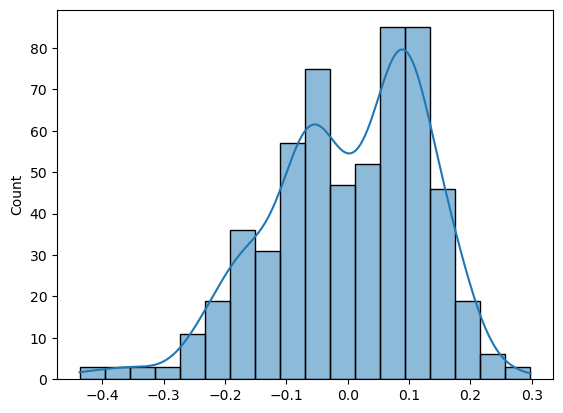

In [208]:
sns.histplot((y_train_br -y_train_pred_br), kde = True )

#### So far it looks centered around zero , but not very normal curve

In [209]:
### Lets drop windspeed and check again

In [210]:
X_train_br_rfe_temp.drop('windspeed', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const        0.253511
year         0.185090
casual       0.712450
weekday_6   -0.142656
month_10     0.056530
dtype: float64

In [211]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     292.7
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.76e-137
Time:                        11:26:09   Log-Likelihood:                 365.02
No. Observations:                 584   AIC:                            -720.0
Df Residuals:                     579   BIC:                            -698.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2535      0.010     26.164      0.000       0.234       0.273
year           0.1851      0.011     16.606      0.000       0.163       0.207
casual         0.7124      0.029     24.381      0.000       0.655       0.770
weekday_6     -0.1427      0.016     -8.725      0.000      -0.175      -0.111
month_10       0.0565      0.019      3.036      0.003       0.020       0.093
==============================================================================
Omnibus:                       28.111   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.242
Skew:                          -0.566   Prob(JB):                     1.64e-07
Kurtosis:                       3.039   Cond. No.                         6.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [212]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
1,casual,2.35
0,year,1.79
2,weekday_6,1.39
3,month_10,1.08


<Axes: ylabel='Count'>

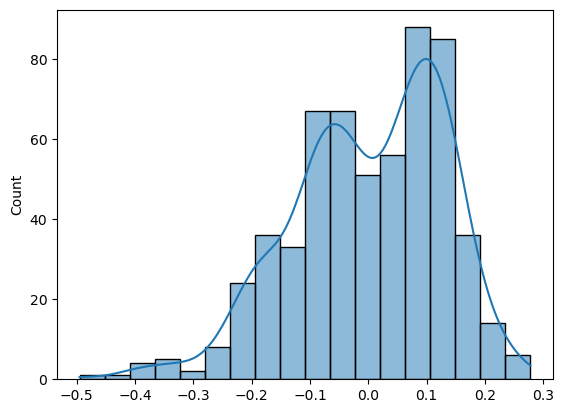

In [213]:
y_train_pred_br = lr_model.predict(sm.add_constant(X_train_br_rfe_temp))
sns.histplot((y_train_br -y_train_pred_br), kde = True )

In [214]:
X_train_br_rfe_temp.drop('weekday_6', axis=1, inplace=True)
lr_model = fit_to_stats_model(X_train_br_rfe_temp, y_train_br)
lr_model.params

const       0.250431
year        0.198236
casual      0.613120
month_10    0.060973
dtype: float64

In [215]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     323.0
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          2.87e-123
Time:                        11:26:19   Log-Likelihood:                 328.95
No. Observations:                 584   AIC:                            -649.9
Df Residuals:                     580   BIC:                            -632.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2504      0.010     24.335      0.000       0.230       0.271
year           0.1982      0.012     16.889      0.000       0.175       0.221
casual         0.6131      0.029     21.436      0.000       0.557       0.669
month_10       0.0610      0.020      3.082      0.002       0.022       0.100
==============================================================================
Omnibus:                       15.799   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.736
Skew:                          -0.339   Prob(JB):                     0.000631
Kurtosis:                       2.618   Cond. No.                         6.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [216]:
calc_vif(X_train_br_rfe_temp)

,Features,VIF
1,casual,1.81
0,year,1.76
2,month_10,1.08


<Axes: ylabel='Count'>

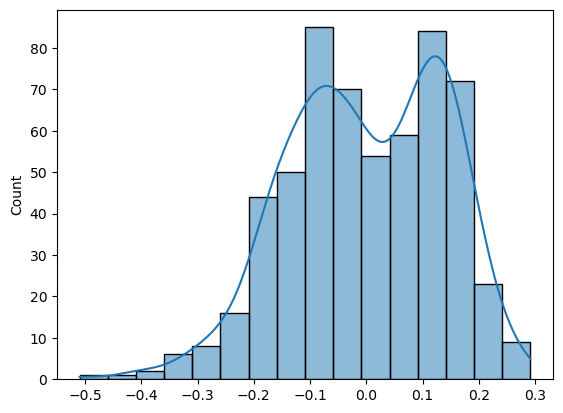

In [217]:
y_train_pred_br = lr_model.predict(sm.add_constant(X_train_br_rfe_temp))
sns.histplot((y_train_br -y_train_pred_br), kde = True )

In [218]:
X_train_br_rfe_temp_sm = X_test_br[X_train_br_rfe_temp.columns]

In [219]:
X_train_br_rfe_temp_sm = sm.add_constant(X_train_br_rfe_temp_sm)

<Axes: ylabel='Count'>

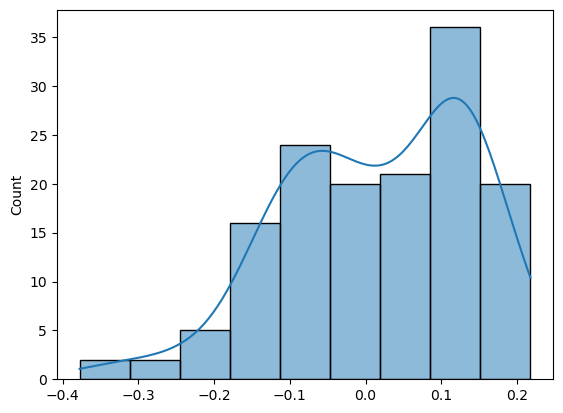

In [220]:
y_test_pred_br = lr_model.predict(X_train_br_rfe_temp_sm)
sns.histplot((y_test_br - y_test_pred_br), kde = True)

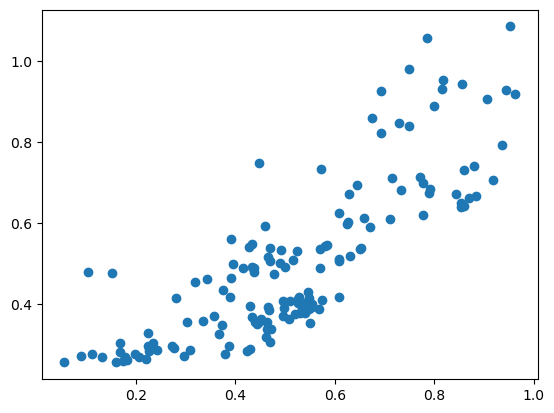

In [221]:
plt.scatter(y_test_br, y_test_pred_br)

#### The above model shows good r2 and also it is consistent with respect to test and train data sets
#### However since residual is not perfectly normal, lets do RFE with 4 variables and see, if it matches

# Method3.3: ( Model building ) Start with RFE of 4 and using randing to decide and analysis so far to decide

### Prioritize collinearity in the beginning

In [222]:
lm = LinearRegression()
lm.fit(X_train_br, y_train_br ) 
# we do not need constant for Liner Regression from sklearn

rfe_br = RFE(estimator=lm, n_features_to_select=3)
rfe_br = rfe_br.fit(X_train_br, y_train_br)

In [223]:
list(zip(X_train_br.columns, rfe_br.support_, rfe_br.ranking_))

[('year', np.False_, np.int64(4)),
 ('holiday', np.False_, np.int64(20)),
 ('workingday', np.False_, np.int64(12)),
 ('temperature', np.True_, np.int64(1)),
 ('perceived_temperature', np.False_, np.int64(9)),
 ('humidity', np.False_, np.int64(5)),
 ('windspeed', np.False_, np.int64(2)),
 ('casual', np.True_, np.int64(1)),
 ('registered', np.True_, np.int64(1)),
 ('season_summer', np.False_, np.int64(8)),
 ('season_fall', np.False_, np.int64(11)),
 ('season_winter', np.False_, np.int64(13)),
 ('weekday_1', np.False_, np.int64(27)),
 ('weekday_2', np.False_, np.int64(24)),
 ('weekday_3', np.False_, np.int64(26)),
 ('weekday_4', np.False_, np.int64(23)),
 ('weekday_5', np.False_, np.int64(19)),
 ('weekday_6', np.False_, np.int64(6)),
 ('weather_situation_Mist', np.False_, np.int64(22)),
 ('weather_situation_Light_Rain', np.False_, np.int64(16)),
 ('month_2', np.False_, np.int64(29)),
 ('month_3', np.False_, np.int64(17)),
 ('month_4', np.False_, np.int64(15)),
 ('month_5', np.False_, np.i

#### Exclude registered , casual from the beginning. 
#### Build a set of 8 with the help of RFE and ranking

In [225]:
calc_vif(X_train_br[['temperature','weekday_6','windspeed','year','month_10','month_11','month_8','workingday','season_winter','month_12']])

,Features,VIF
8,season_winter,6.42
0,temperature,4.96
7,workingday,3.84
2,windspeed,3.42
4,month_10,3.34
5,month_11,3.09
9,month_12,2.01
3,year,2.01
1,weekday_6,1.65
6,month_8,1.29


#### Above set looks good in terms of collinearity , except season winter

In [226]:
calc_vif(X_train_br[['temperature','weekday_6','windspeed','year','month_10','month_11','month_8','workingday','month_12']])

,Features,VIF
0,temperature,4.91
7,workingday,3.82
2,windspeed,3.36
3,year,2.01
1,weekday_6,1.65
6,month_8,1.28
4,month_10,1.12
8,month_12,1.12
5,month_11,1.10


#### VIF looks fine, lets build model

In [227]:
X_train_br_new = X_train_br[['temperature','weekday_6','windspeed','year','month_10','month_11','month_8','workingday','month_12']]
lr_model = fit_to_stats_model(X_train_br_new, y_train_br)
lr_model.params

const          0.063625
temperature    0.619406
weekday_6      0.066152
windspeed     -0.190572
year           0.234287
month_10       0.089273
month_11       0.077250
month_8       -0.027348
workingday     0.053801
month_12       0.022107
dtype: float64

In [228]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     179.6
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.51e-160
Time:                        11:27:27   Log-Likelihood:                 433.12
No. Observations:                 584   AIC:                            -846.2
Df Residuals:                     574   BIC:                            -802.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0636      0.022      2.910      0.004       0.021       0.107
temperature     0.6194      0.025     24.750      0.000       0.570       0.669
weekday_6       0.0662      0.017      3.934      0.000       0.033       0.099
windspeed      -0.1906      0.029     -6.462      0.000      -0.248      -0.133
year            0.2343      0.010     24.245      0.000       0.215       0.253
month_10        0.0893      0.017      5.265      0.000       0.056       0.123
month_11        0.0773      0.018      4.191      0.000       0.041       0.113
month_8        -0.0273      0.018     -1.504      0.133      -0.063       0.008
workingday      0.0538      0.013      4.213      0.000       0.029       0.079
month_12        0.0221      0.018      1.208      0.228      -0.014       0.058
==============================================================================
Omnibus:                       73.948   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.866
Skew:                          -0.780   Prob(JB):                     3.83e-29
Kurtosis:                       4.716   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Remove month_8 based on p value

In [229]:
X_train_br_new = X_train_br[['temperature','weekday_6','windspeed','year','month_10','month_11','workingday','month_12']]
lr_model = fit_to_stats_model(X_train_br_new, y_train_br)
lr_model.params

const          0.067464
temperature    0.606862
weekday_6      0.065664
windspeed     -0.189456
year           0.234396
month_10       0.092101
month_11       0.078235
workingday     0.053375
month_12       0.022393
dtype: float64

In [230]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     201.3
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          3.17e-161
Time:                        11:27:35   Log-Likelihood:                 431.97
No. Observations:                 584   AIC:                            -845.9
Df Residuals:                     575   BIC:                            -806.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0675      0.022      3.103      0.002       0.025       0.110
temperature     0.6069      0.024     25.692      0.000       0.560       0.653
weekday_6       0.0657      0.017      3.901      0.000       0.033       0.099
windspeed      -0.1895      0.030     -6.419      0.000      -0.247      -0.131
year            0.2344      0.010     24.231      0.000       0.215       0.253
month_10        0.0921      0.017      5.460      0.000       0.059       0.125
month_11        0.0782      0.018      4.242      0.000       0.042       0.114
workingday      0.0534      0.013      4.176      0.000       0.028       0.078
month_12        0.0224      0.018      1.222      0.222      -0.014       0.058
==============================================================================
Omnibus:                       70.171   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.239
Skew:                          -0.745   Prob(JB):                     1.05e-27
Kurtosis:                       4.698   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [231]:
calc_vif(X_train_br_new)

,Features,VIF
0,temperature,4.31
6,workingday,3.82
2,windspeed,3.32
3,year,2.01
1,weekday_6,1.65
7,month_12,1.12
4,month_10,1.10
5,month_11,1.09


#### Remove month_12 based on p value

In [232]:
X_train_br_new = X_train_br[['temperature','weekday_6','windspeed','year','month_10','month_11','workingday']]
lr_model = fit_to_stats_model(X_train_br_new, y_train_br)
lr_model.params

const          0.076419
temperature    0.597235
weekday_6      0.066124
windspeed     -0.194326
year           0.234649
month_10       0.089439
month_11       0.074337
workingday     0.053511
dtype: float64

In [233]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     229.6
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          4.24e-162
Time:                        11:27:45   Log-Likelihood:                 431.21
No. Observations:                 584   AIC:                            -846.4
Df Residuals:                     576   BIC:                            -811.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0764      0.020      3.732      0.000       0.036       0.117
temperature     0.5972      0.022     26.808      0.000       0.553       0.641
weekday_6       0.0661      0.017      3.928      0.000       0.033       0.099
windspeed      -0.1943      0.029     -6.642      0.000      -0.252      -0.137
year            0.2346      0.010     24.252      0.000       0.216       0.254
month_10        0.0894      0.017      5.345      0.000       0.057       0.122
month_11        0.0743      0.018      4.091      0.000       0.039       0.110
workingday      0.0535      0.013      4.185      0.000       0.028       0.079
==============================================================================
Omnibus:                       66.042   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.695
Skew:                          -0.718   Prob(JB):                     2.05e-25
Kurtosis:                       4.615   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [234]:
calc_vif(X_train_br_new)

,Features,VIF
0,temperature,4.21
6,workingday,3.69
2,windspeed,3.30
3,year,1.99
1,weekday_6,1.61
4,month_10,1.10
5,month_11,1.08


#### Now do prediction on the train set and plot residual

<Axes: ylabel='Count'>

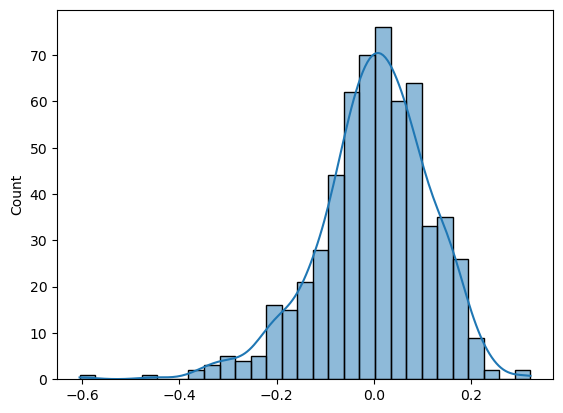

In [235]:
y_train_pred_br = lr_model.predict(sm.add_constant(X_train_br_new))
sns.histplot((y_train_br -y_train_pred_br), kde = True )

#### Do prediction on the test set and plot residual

In [236]:
X_test_br_new = X_test_br[X_train_br_new.columns]

In [237]:
X_test_br_new.head()

,temperature,weekday_6,windspeed,year,month_10,month_11,workingday
184,0.831783,0,0.084219,0,0,0,0
535,0.901354,0,0.153728,1,0,0,1
299,0.511964,0,0.334206,0,1,0,1
221,0.881625,0,0.339570,0,0,0,1
152,0.817246,0,0.537414,0,0,0,1


In [238]:
X_test_br_new = sm.add_constant(X_test_br_new)

<Axes: ylabel='Count'>

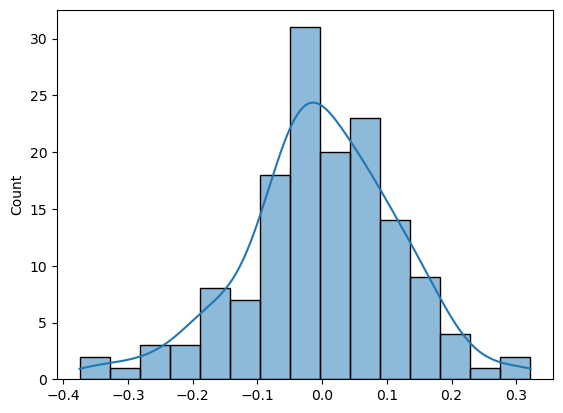

In [239]:
y_test_pred_br = lr_model.predict(X_test_br_new)
sns.histplot((y_test_br - y_test_pred_br), kde = True )


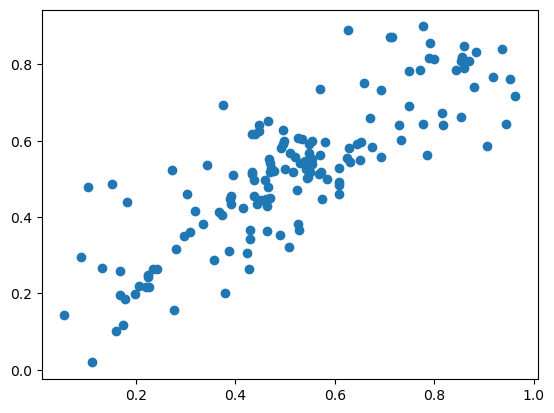

In [240]:
plt.scatter(y_test_br, y_test_pred_br)

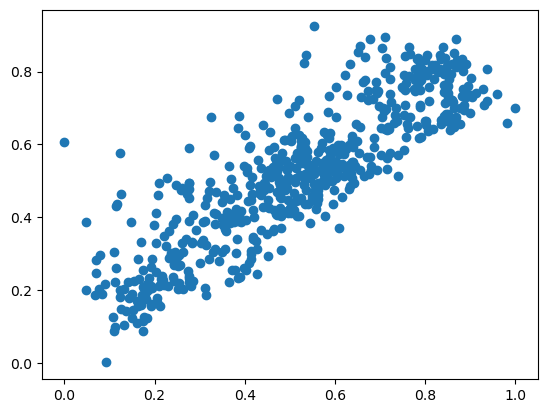

In [241]:
plt.scatter(y_train_br, y_train_pred_br)

### So the model with variable 'temperature','weekday_6','windspeed','year','month_10','month_11','workingday' looks to be a good model with R2 as .736
### VIF for all predictor variables is less that 0.5
### there is good correlation between test and train

In [242]:
r2_score(y_test_br, y_test_pred_br)

0.6862208592021961

In [243]:
r2_score(y_train_br, y_train_pred_br)

0.7362050090024452

### The R2 square on the test set one is 5% of train set
### this model from all measures  R2, residual, scatter plot . Looks like a good model

#### Model looks better when without registered and casual, lets try an RFE excluding regsitered casual from the data set

# Method3.4: ( Model building ) Start with RFE of 10 excluding registered and casual

In [244]:
X_test_br.columns

Index(['year', 'holiday', 'workingday', 'temperature', 'perceived_temperature',
       'humidity', 'windspeed', 'casual', 'registered', 'season_summer',
       'season_fall', 'season_winter', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weather_situation_Mist',
       'weather_situation_Light_Rain', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [245]:
X_train_br_temp = X_train_br.drop(['registered', 'casual'], axis = 1)

In [246]:
X_train_br_temp.columns

Index(['year', 'holiday', 'workingday', 'temperature', 'perceived_temperature',
       'humidity', 'windspeed', 'season_summer', 'season_fall',
       'season_winter', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weather_situation_Mist',
       'weather_situation_Light_Rain', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [247]:
lm = LinearRegression()
lm.fit(X_train_br_temp, y_train_br ) 
# we do not need constant for Liner Regression from sklearn

rfe_br = RFE(estimator=lm, n_features_to_select=10)
rfe_br = rfe_br.fit(X_train_br_temp, y_train_br)

In [248]:
list(zip(X_train_br_temp.columns, rfe_br.support_, rfe_br.ranking_))

[('year', np.True_, np.int64(1)),
 ('holiday', np.True_, np.int64(1)),
 ('workingday', np.False_, np.int64(3)),
 ('temperature', np.True_, np.int64(1)),
 ('perceived_temperature', np.False_, np.int64(6)),
 ('humidity', np.True_, np.int64(1)),
 ('windspeed', np.True_, np.int64(1)),
 ('season_summer', np.True_, np.int64(1)),
 ('season_fall', np.False_, np.int64(7)),
 ('season_winter', np.True_, np.int64(1)),
 ('weekday_1', np.False_, np.int64(14)),
 ('weekday_2', np.False_, np.int64(15)),
 ('weekday_3', np.False_, np.int64(19)),
 ('weekday_4', np.False_, np.int64(20)),
 ('weekday_5', np.False_, np.int64(16)),
 ('weekday_6', np.False_, np.int64(2)),
 ('weather_situation_Mist', np.True_, np.int64(1)),
 ('weather_situation_Light_Rain', np.True_, np.int64(1)),
 ('month_2', np.False_, np.int64(12)),
 ('month_3', np.False_, np.int64(8)),
 ('month_4', np.False_, np.int64(11)),
 ('month_5', np.False_, np.int64(9)),
 ('month_6', np.False_, np.int64(10)),
 ('month_7', np.False_, np.int64(13)),
 ('

In [249]:
col = X_train_br_temp.columns[rfe_br.support_]
X_train_br_temp = X_train_br_temp[col]



In [250]:

calc_vif(X_train_br_temp)

,Features,VIF
3,humidity,14.18
2,temperature,7.97
4,windspeed,3.59
7,weather_situation_Mist,2.11
0,year,2.01
6,season_winter,1.63
5,season_summer,1.59
9,month_9,1.20
8,weather_situation_Light_Rain,1.15
1,holiday,1.04


In [251]:
lr_model = fit_to_stats_model(X_train_br_temp, y_train_br)
lr_model.params

const                           0.212376
year                            0.224963
holiday                        -0.106261
temperature                     0.588705
humidity                       -0.171595
windspeed                      -0.181213
season_summer                   0.092349
season_winter                   0.146014
weather_situation_Mist         -0.049668
weather_situation_Light_Rain   -0.239914
month_9                         0.099845
dtype: float64

In [252]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     301.4
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          8.52e-221
Time:                        11:29:00   Log-Likelihood:                 577.71
No. Observations:                 584   AIC:                            -1133.
Df Residuals:                     573   BIC:                            -1085.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2124      0.026      8.240      0.000       0.162       0.263
year                             0.2250      0.008     29.536      0.000       0.210       0.240
holiday                         -0.1063      0.023     -4.585      0.000      -0.152      -0.061
temperature                      0.5887      0.019     31.460      0.000       0.552       0.625
humidity                        -0.1716      0.036     -4.772      0.000      -0.242      -0.101
windspeed                       -0.1812      0.024     -7.453      0.000      -0.229      -0.133
season_summer                    0.0923      0.010      9.660      0.000       0.074       0.111
season_winter                    0.1460      0.010     15.169      0.000       0.127       0.165
weather_situation_Mist          -0.0497      0.010     -4.989      0.000      -0.069      -0.030
weather_situation_Light_Rain    -0.2399      0.026     -9.383      0.000      -0.290      -0.190
month_9                          0.0998      0.015      6.845      0.000       0.071       0.128
==============================================================================
Omnibus:                       76.521   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.086
Skew:                          -0.737   Prob(JB):                     6.36e-36
Kurtosis:                       5.118   Cond. No.                         18.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### R2 is good. Lets drop humidity according to vif

In [253]:
X_train_br_temp = X_train_br_temp.drop('humidity',axis = 1)
lr_model = fit_to_stats_model(X_train_br_temp, y_train_br)
lr_model.params

const                           0.113226
year                            0.229605
holiday                        -0.106351
temperature                     0.567737
windspeed                      -0.148427
season_summer                   0.090452
season_winter                   0.137566
weather_situation_Mist         -0.077475
weather_situation_Light_Rain   -0.287761
month_9                         0.093946
dtype: float64

In [254]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     320.3
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          3.17e-217
Time:                        11:29:09   Log-Likelihood:                 566.33
No. Observations:                 584   AIC:                            -1113.
Df Residuals:                     574   BIC:                            -1069.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1132      0.016      7.288      0.000       0.083       0.144
year                             0.2296      0.008     29.834      0.000       0.214       0.245
holiday                         -0.1064      0.024     -4.505      0.000      -0.153      -0.060
temperature                      0.5677      0.019     30.636      0.000       0.531       0.604
windspeed                       -0.1484      0.024     -6.247      0.000      -0.195      -0.102
season_summer                    0.0905      0.010      9.295      0.000       0.071       0.110
season_winter                    0.1376      0.010     14.272      0.000       0.119       0.156
weather_situation_Mist          -0.0775      0.008     -9.421      0.000      -0.094      -0.061
weather_situation_Light_Rain    -0.2878      0.024    -12.008      0.000      -0.335      -0.241
month_9                          0.0939      0.015      6.345      0.000       0.065       0.123
==============================================================================
Omnibus:                       69.732   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.772
Skew:                          -0.692   Prob(JB):                     1.64e-31
Kurtosis:                       4.978   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [255]:
calc_vif(X_train_br_temp)

,Features,VIF
2,temperature,3.73
3,windspeed,3.03
0,year,2.00
4,season_summer,1.58
6,weather_situation_Mist,1.48
5,season_winter,1.37
8,month_9,1.20
7,weather_situation_Light_Rain,1.07
1,holiday,1.04


#### R2 did not drop significantly , P values are all zeros and VIF of all variables are less than 5

#### Lets evaluate the model now
#### Plotting residuals

<Axes: ylabel='Count'>

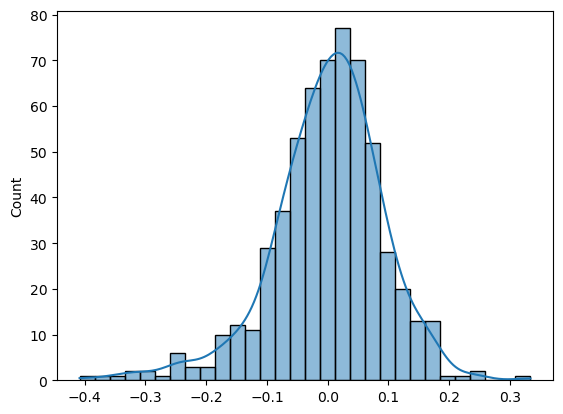

In [256]:
y_train_pred_br = lr_model.predict(sm.add_constant(X_train_br_temp))
sns.histplot((y_train_br -y_train_pred_br), kde = True )

##### Residual plot is a normal curve for train data set
##### Now plotting for test data set

In [257]:
X_test_br_temp = X_test_br[X_train_br_temp.columns]

<Axes: ylabel='Count'>

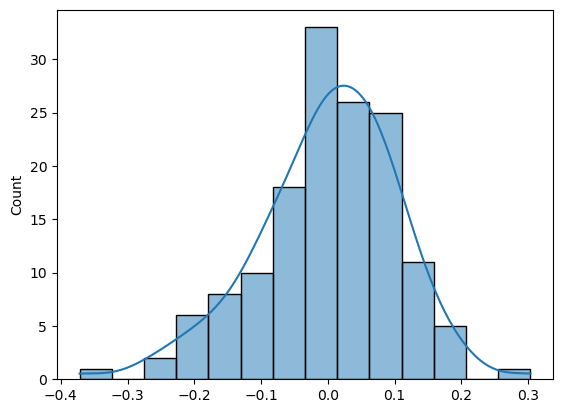

In [258]:
X_test_br_temp = sm.add_constant(X_test_br_temp)
y_test_pred_br = lr_model.predict(X_test_br_temp)
sns.histplot((y_test_br - y_test_pred_br), kde = True )

#### Residual plot for test data set is also normal, centered around zero

#### Scatter plot between test and pred

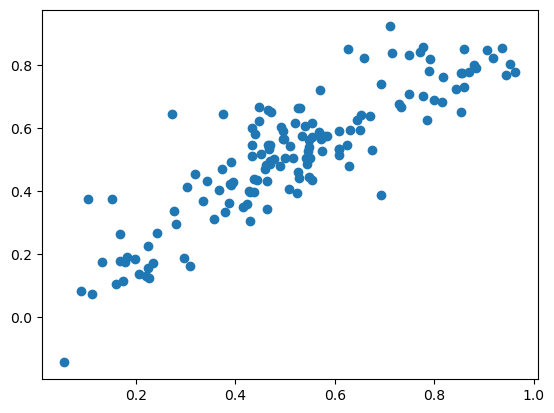

In [259]:
plt.scatter(y_test_br, y_test_pred_br)

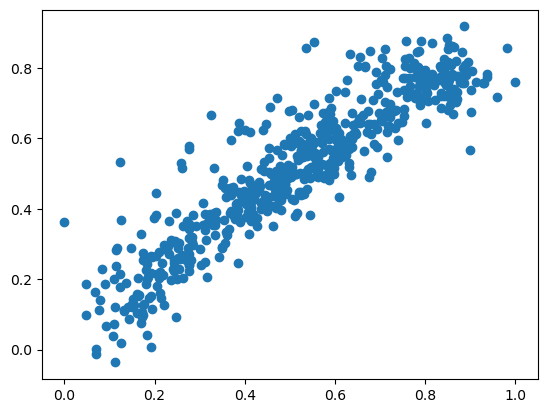

In [260]:
plt.scatter(y_train_br, y_train_pred_br)

#### Now compare the R2 value

In [261]:
r2_score(y_test_br, y_test_pred_br)

0.7544238208820536

In [262]:
r2_score(y_train_br, y_train_pred_br)

0.833925231017

#### Checking variables with strong influence

In [263]:
lr_model.params.sort_values(ascending=False)

temperature                     0.567737
year                            0.229605
season_winter                   0.137566
const                           0.113226
month_9                         0.093946
season_summer                   0.090452
weather_situation_Mist         -0.077475
holiday                        -0.106351
windspeed                      -0.148427
weather_situation_Light_Rain   -0.287761
dtype: float64

In [264]:
lr_model.params.abs().sort_values(ascending=False)

temperature                     0.567737
weather_situation_Light_Rain    0.287761
year                            0.229605
windspeed                       0.148427
season_winter                   0.137566
const                           0.113226
holiday                         0.106351
month_9                         0.093946
season_summer                   0.090452
weather_situation_Mist          0.077475
dtype: float64

#### R2 value of test is 90 % of train. deviation id more than 5%
#### This show overfit of the model.
#### The previous evaluation Method 3.3 gave a better vraince but R2 score was less

#### Conclusion

#### We explored several approaches to build and evaluate our models. Initially, when registered and casual variables were included in the training data (X_train), we observed high variance in parameter estimates whenever variables were added or removed manually. To address this, we adopted a combination of automated and manual feature selection methods.

#### Given that the dataset shows a direct linear relationship between registered, casual, and count, we decided to exclude the first two variables and reevaluate the model. Two approaches were followed in this phase:

#### RFE with registered and casual included in input: Although RFE ranked all variables, we manually dropped registered and casual based on domain understanding. This model achieved an R² of approximately 70%, with a test-set variance within 5%.

#### RFE without registered and casual in input: This approach resulted in a higher R2, but the variance between train and test R2 values exceeded 5%.

#### Considering residual analysis, p-values, and R2 scores, we conclude that the model built using RFE without registered and casual provides the most reliable and interpretable performance.
